![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Machine Learning for Finance - Assignment 1

### by Amber Walker and Clarice Mottet
### All work was distributed and completed equally.

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

1. **[Part 1: EWMA Based Variance](#part1)**
- **Objective**: Compare two models to calculate EWMA Based Variance
- **Tasks:**
  - EWMA Equation: Use the equation covered in class to calculate EWMA based variance.
  - EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.
  - Calculate regular historical volatility.
  - Compare the two methods to calculate EWMA based variance to the regular historical volatility benchmark.

2. **[Part 2: Causality Analysis](#part2)**
- **Objective**: Conduct causality analysis with multiple lag variables and time frame windows.
- **Tasks:**
  - Perform stationary test for relevant time period. Manipulate data if necessary.
  - Resample the time series to the weekly and monthly level.
  - Lag 4 returns, lag 4 volatility
  - Perform causality analysis: 4 tables (weekly, returns), (monthly, returns), (weekly, volatility), (monthly, volatility)
  - Correlation assessment

3. **[Part 3: Modeling](#part3)**
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - (I think we should predict a binary outcome of the stock direction goes up or down personally)
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: (I'd suggest a good old random forest cause I personally love a random forest feature selection or an XGBoost feature selection).
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.

4. **[Part 4: Further Analysis](#part4)**
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model and compare to the neural network and gaussian process.
  - Discuss if bootstrapping would aid model performance and efficacy and what modeling would look like with the incorporation of stationary bootstrapping.


## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

In [ ]:
!pip install panelsplit > /dev/null # installation of PanelSplit
!pip3 install pmdarima
!pip3 install arch

In [1]:
#Libraries
import pandas as pd
import numpy as np
import os
import gc
import datetime
import yfinance as yf
# from google.colab import drive
# drive.mount('/content/drive')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.figure_factory as ff
import plotly.io as pio

#Paths
path_in_ = r'/home/clarice/Documents/VSCode/Term3/ML_Finance/MLF_HW1/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term3/ML_Finance/MLF_HW1/outputs/'
# path_in_ = r'/content/drive/MyDrive/ML_Finance/MLF_HW1/inputs/'
# path_out_ = r'/content/drive/MyDrive/ML_Finance/MLF_HW1/outputs/'

#Global Variables

#used in EWMA calculations
PARAM_LAMBDA = .94


from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from google.colab import drive
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C, RationalQuadratic, ExpSineSquared, RBF, Sum, Product, WhiteKernel, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import recall_score, precision_score, explained_variance_score, accuracy_score, classification_report, roc_auc_score, accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from panelsplit import PanelSplit
from sklearn.impute import KNNImputer
import seaborn as sns

# statsmodels for statistical methods
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import het_arch
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# scipy stats for shapiro test
from scipy import stats
from pmdarima.arima import auto_arima
from arch import arch_model

drive.mount('/content/drive')


In [2]:
#Import

#using a text file we created from an R file
df_market = pd.read_csv(path_in_ + 'WorldMarkets99_20.txt', sep = '|', dtype = str)
df_market.columns = df_market.columns.str.lower().str.strip()
df_market[['open','high','low','close','volume','adjusted']] = df_market[['open','high','low','close','volume','adjusted']].apply(pd.to_numeric)
df_market['date'] = pd.to_datetime(df_market['date'])
df_market.sort_values(by = ['market','date'], inplace = True)
df_market.reset_index(drop = True, inplace = True)

df_market.describe()

,open,high,low,close,volume,adjusted,date
count,69035.000000,69035.000000,69035.000000,69035.000000,6.903500e+04,69035.000000,70078
mean,11464.128611,11555.368887,11366.426424,11462.595335,4.028610e+08,11462.588664,2009-08-02 18:18:57.361225984
min,9.010000,9.310000,8.560000,9.140000,0.000000e+00,9.140000,1999-01-04 00:00:00
25%,1891.545044,1907.417481,1872.669983,1890.239990,8.400000e+03,1890.239990,2004-03-19 00:00:00
50%,6737.540039,6785.109863,6682.490234,6733.229980,4.237800e+06,6733.204102,2009-07-21 00:00:00
75%,11869.479981,11951.899903,11773.080078,11867.850098,1.535236e+08,11867.850098,2014-12-09 00:00:00
max,119528.000000,119593.000000,118108.000000,119528.000000,1.145623e+10,119528.000000,2020-04-30 00:00:00
std,15447.245090,15581.477219,15309.464143,15448.944086,9.914707e+08,15448.946777,NaN


First, we fetch the data from 12/30/98 for each market and add it to our df so that we can .ffill() that data to the first missing values. There is no data for the 31st, so we get the data for the 30th.

In [6]:
#fetch the data for 12/30/98
market_symbols = [
    "^BSESN", "^BVSP", "^FTSE", "^GDAXI", "^GSPC", "^HSCE",
    "^IBEX", "^JKSE", "^MXX", "^N225", "^TWII", "^VLIC", "^VIX"
]
market_countries = [
    "India", "Brazil", "UK", "Germany", "USA", "China-Shanghai",
    "Spain", "Indonesia", "Mexico", "Japan", "Taiwan", "VLIC", "VIX"
]

start_date = datetime.datetime(1998, 12, 30)
end_date = datetime.datetime(1998, 12, 31)

# Function to retrieve and store market data using yfinance
def get_market_data(symbols, start, end):
    data = {}
    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            data[symbol] = ticker.history(start=start, end=end, auto_adjust=False)
        except Exception as e:
            print(f"Failed to retrieve data for {symbol}: {str(e)}")
    return data

def prepare_data_for_merge(day_before_data):
    all_data = []
    for symbol, df in day_before_data.items():
        if not df.empty:
            df['market'] = symbol  # Add a 'Symbol' column to each DataFrame
            all_data.append(df)
    combined_df = pd.concat(all_data)
    return combined_df

In [7]:
#get market data
day_before_data = get_market_data(market_symbols, start_date, end_date)

# for symbol in market_symbols:
#   print(day_before_data[symbol])

combined_df = prepare_data_for_merge(day_before_data)

In [8]:
combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,market,Capital Gains
Date,,,,,,,,,,
1998-12-30 00:00:00+05:30,3074.439941,3118.590088,3072.610107,3110.330078,3110.330078,0,0.0,0.0,^BSESN,NaN
1998-12-30 00:00:00-02:00,6715.000000,6865.000000,6712.000000,6784.000000,6784.000000,0,0.0,0.0,^BVSP,NaN
1998-12-30 00:00:00+00:00,5932.700195,5944.899902,5809.000000,5882.600098,5882.600098,0,0.0,0.0,^FTSE,NaN
1998-12-30 00:00:00+01:00,5054.859863,5089.229980,4999.709961,5006.569824,5006.569824,0,0.0,0.0,^GDAXI,NaN
1998-12-30 00:00:00-05:00,1241.810059,1244.930054,1231.199951,1231.930054,1231.930054,594220000,0.0,0.0,^GSPC,NaN


In [9]:
#clean data
combined_df = combined_df.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
combined_df = combined_df.reset_index()
combined_df.rename(columns={'index': 'date'}, inplace=True)
combined_df.rename(columns={'Adj Close': 'adjusted'}, inplace=True)
combined_df.columns = combined_df.columns.str.lower()
combined_df['market'] = combined_df['market'].str.replace('^', '', regex=False)

#remove the timezone
if 'date' in combined_df.columns:
    combined_df['date'] = pd.to_datetime(combined_df['date'], utc=True)
    combined_df['date'] = combined_df['date'].dt.tz_localize(None)
    combined_df['date'] = combined_df['date'].dt.date

display(combined_df.head())

,date,open,high,low,close,adjusted,volume,market
0,1998-12-29,3074.439941,3118.590088,3072.610107,3110.330078,3110.330078,0,BSESN
1,1998-12-30,6715.000000,6865.000000,6712.000000,6784.000000,6784.000000,0,BVSP
2,1998-12-30,5932.700195,5944.899902,5809.000000,5882.600098,5882.600098,0,FTSE
3,1998-12-29,5054.859863,5089.229980,4999.709961,5006.569824,5006.569824,0,GDAXI
4,1998-12-30,1241.810059,1244.930054,1231.199951,1231.930054,1231.930054,594220000,GSPC


### Add missing dates

In [10]:
#first we build a df with all dates (including weekends) for EACH market
start_date = datetime.datetime(1999, 1, 1)
end_date = datetime.datetime(2020, 4, 30)
#date range
dates = pd.date_range(start=start_date, end=end_date, freq='D')
#all of the diff markets
markets = df_market['market'].unique()
#df build
date_df = pd.DataFrame([(date, market) for market in markets for date in dates], columns=['date', 'market'])

print(date_df.head())


        date market
0 1999-01-01  BSESN
1 1999-01-02  BSESN
2 1999-01-03  BSESN
3 1999-01-04  BSESN
4 1999-01-05  BSESN


In [11]:
#merge the market df onto the date_df, so all dates are included
df = date_df.merge(df_market, on=['date', 'market'], how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101283 entries, 0 to 101282
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      101283 non-null  datetime64[ns]
 1   market    101283 non-null  object        
 2   open      69035 non-null   float64       
 3   high      69035 non-null   float64       
 4   low       69035 non-null   float64       
 5   close     69035 non-null   float64       
 6   volume    69035 non-null   float64       
 7   adjusted  69035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.2+ MB


In [12]:
#add on the new data
combined_df['date'] = pd.to_datetime(combined_df['date'])
df['date'] = pd.to_datetime(df['date'])
df = pd.concat([df, combined_df], ignore_index=True).copy()
df = df.sort_values(by='date')

print(df.head())

             date market          open          high           low  \
101286 1998-12-29  GDAXI   5054.859863   5089.229980   4999.709961   
101293 1998-12-29   TWII   6545.779785   6566.549805   6433.450195   
101292 1998-12-29   N225  13832.320312  13913.549805  13812.870117   
101283 1998-12-29  BSESN   3074.439941   3118.590088   3072.610107   
101290 1998-12-29   JKSE    396.915985    398.037994    390.084015   

               close     volume      adjusted  
101286   5006.569824        0.0   5006.569824  
101293   6462.029785        0.0   6462.005371  
101292  13842.169922        0.0  13842.169922  
101283   3110.330078        0.0   3110.330078  
101290    398.037994  1748700.0    398.037994  


### Forward Filling

In [13]:
#df.sort_values(by=['market', 'date'], inplace=True)
columns_to_impute = ['open', 'high', 'low', 'close', 'volume', 'adjusted']

for column in columns_to_impute:
    df[column] = df.groupby(['market'])[column].fillna(method='ffill')

nulls = df.isna().sum()

print(nulls)

date        0
market      0
open        0
high        0
low         0
close       0
volume      0
adjusted    0
dtype: int64


/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[column] = df.groupby(['market'])[column].fillna(method='ffill')
/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(['market'])[column].fillna(method='ffill')
/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[column] = df.groupby(['market'])[column].fillna(method='ffill')
/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: Series.fillna with 'method' is de

In [14]:
df_clean = df[df['date'] >= pd.Timestamp('1999-01-01')]
print(df_clean.head())

            date market         open          high          low        close  \
23373 1999-01-01  GDAXI  5054.859863   5089.229980  4999.709961  5006.569824   
31164 1999-01-01   GSPC  1241.810059   1244.930054  1231.199951  1231.930054   
38955 1999-01-01   HSCE  1715.569946   1733.900024  1706.359985  1724.469971   
46746 1999-01-01   IBEX  9940.700195  10054.900391  9822.200195  9836.599609   
93492 1999-01-01   VLIC   427.079987    428.839996   426.570007   428.420013   

            volume     adjusted  
23373          0.0  5006.569824  
31164  594220000.0  1231.930054  
38955          0.0  1724.469971  
46746          0.0  9836.589844  
93492    5970000.0   428.420013  


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101283 entries, 23373 to 77909
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      101283 non-null  datetime64[ns]
 1   market    101283 non-null  object        
 2   open      101283 non-null  float64       
 3   high      101283 non-null  float64       
 4   low       101283 non-null  float64       
 5   close     101283 non-null  float64       
 6   volume    101283 non-null  float64       
 7   adjusted  101283 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 7.0+ MB


In pandas, the dayofweek attribute returns an integer for each date, where Monday is 0 and Sunday is 6. Saturday (5) and Sunday (6) can be identified as weekends.

In [16]:
#we use the pandas dayofweek attribute to create a new feature indicating whether the day is on the weekend or not
df_clean['weekend'] = (df_clean['date'].dt.dayofweek > 4).astype(int)

print(df_clean.head)

<bound method NDFrame.head of             date market          open          high           low  \
23373 1999-01-01  GDAXI   5054.859863   5089.229980   4999.709961   
31164 1999-01-01   GSPC   1241.810059   1244.930054   1231.199951   
38955 1999-01-01   HSCE   1715.569946   1733.900024   1706.359985   
46746 1999-01-01   IBEX   9940.700195  10054.900391   9822.200195   
93492 1999-01-01   VLIC    427.079987    428.839996    426.570007   
...          ...    ...           ...           ...           ...   
7790  2020-04-30  BSESN  32311.039063  32897.589844  32171.650391   
93491 2020-04-30    VIX     32.480000     33.189999     30.709999   
85700 2020-04-30   TWII  10656.400391  10794.830078  10656.400391   
70118 2020-04-30    MXX  36095.718750  36976.648438  36095.718750   
77909 2020-04-30   N225  20105.679688  20365.890625  20084.830078   

              close       volume      adjusted  weekend  
23373   5006.569824          0.0   5006.569824        0  
31164   1231.930054  5942

/tmp/ipykernel_16017/2837093159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['weekend'] = (df_clean['date'].dt.dayofweek > 4).astype(int)


In [17]:
nulls = df_clean.isna().sum()

print(nulls)

date        0
market      0
open        0
high        0
low         0
close       0
volume      0
adjusted    0
weekend     0
dtype: int64


In [ ]:
# df_clean.to_csv(path_out_ + 'df_clean.csv', index=False)

## <a id='part1'>Part 1: EWMA Based Variance</a>
- **Objective**: Compare two models to calculate EWMA Based Variance
- **Tasks:**
  - EWMA Equation: Use the equation covered in class to calculate EWMA based variance.
  - EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.
  - Calculate regular historical volatility.
  - Compare the two methods to calculate EWMA based variance to the regular historical volatility benchmark.

- Import in the cleaned stock data.

In [2]:
#Import in the cleaned stock data

df_stocks = pd.read_csv(path_out_ + 'df_clean.csv', dtype = str)
df_stocks['date'] = pd.to_datetime(df_stocks['date'])
df_stocks[['open', 'high', 'low', 'close', 'volume', 'adjusted','weekend']] = df_stocks[['open', 'high', 'low', 'close', 'volume', 'adjusted','weekend']].apply(pd.to_numeric)
df_stocks['market'] = df_stocks['market'].str.strip().str.upper()
df_stocks.sort_values(by = ['market','date'], inplace = True)
df_stocks.reset_index(drop = True, inplace = True)

df_stocks['index_time'] = 1
df_stocks['index_time'] = df_stocks.groupby(by = ['market'])['index_time'].cumsum()

#subset to a smaller population
df_stocks = df_stocks[(df_stocks['market']=='BVSP')|(df_stocks['market']=='MXX')|(df_stocks['market']=='VIX')]

df_stocks.dtypes

date          datetime64[ns]
market                object
open                 float64
high                 float64
low                  float64
close                float64
volume               float64
adjusted             float64
weekend                int64
index_time             int64
dtype: object

- Calculate daily log return on close price - (Lecture 2, Slide 5)

$$ r_{t} = ln(P_{t}) - ln(P_{t-1}) $$

In [3]:
#Calculate daily return on close price

#get previous close day
df_stocks['close_lag1'] = df_stocks.groupby(by = ['market'])['close'].shift(1)

#remove the places where we don't have previous day information
df_stocks = df_stocks[df_stocks['index_time']>1]
df_stocks['index_time'] = df_stocks['index_time'] - 1

#use formula to calculate daily natural log return
df_stocks['return_ln_daily'] = np.log(df_stocks['close']) - np.log(df_stocks['close_lag1'])


- EWMA Equation: Use the equation covered in class to calculate EWMA based variance.

$$\sigma^2_{\text{ewma}}(t) = (1 - \lambda) \sum \limits _{k=1} ^{m} \lambda^{k-1}r^2_{t-k}$$

In [4]:
#EWMA Equation

def ewma_formula(t, M, PARAM_M, df_):
    df_calc = df_[(df_['index_time']<=t)&(df_['index_time']>=(t-M))].copy()
    df_calc['index_time_ewma_eqn'] = (t - df_calc['index_time']) - 1
    df_calc['lambda'] = df_calc['index_time_ewma_eqn'].apply(lambda x: PARAM_LAMBDA**x)
    df_calc['index_value'] = df_calc['lambda']*(df_calc['return_ln_daily']**2)
    df_calc.loc[df_calc['index_time']==t, 'index_value'] = 0

    col = 'ewma_eqn'+str(PARAM_M)
    df_calc[col] = df_calc.groupby(by = ['market'])['index_value'].transform('sum')
    df_calc[col] = (1 - PARAM_LAMBDA)*df_calc[col]
    df_calc.sort_values(by = ['market','date'], ascending = [True, False], inplace = True)
    df_calc.drop_duplicates(subset = ['market'], inplace = True)
    df_calc = df_calc[['date','market',col]]
    return df_calc

def ewma_calc(df_, PARAM_M):
    df_days = df_.copy()
    df_days['number_of_days'] = 1
    df_days['number_of_days'] = df_days.groupby(by = ['market'])['number_of_days'].transform('sum')
    df_days.drop_duplicates(subset = ['market'], inplace = True)
    iterations = df_days['number_of_days'].max()

    list_ewma_eqn = []
    for t in range(1, iterations+1):
        if t < PARAM_M:
            M = t
        else:
            M = PARAM_M
        df_ewma_eqn = ewma_formula(t, M, PARAM_M, df_)
        list_ewma_eqn.append(df_ewma_eqn)

    df_all_ewma_eqn = pd.concat(list_ewma_eqn, ignore_index = True)
    df_ = df_.merge(df_all_ewma_eqn, how = 'left', on = ['market','date'])
    return df_

df_stocks = ewma_calc(df_stocks, 20)
df_stocks = ewma_calc(df_stocks, 100)

- EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.

$$\sigma^2_{\text{ewma}}(t) = \lambda \sigma^2_{\text{ewma}}(t-1) + (1-\lambda)r^2_{t-1}$$

In [5]:
#EWMA Recusion

def ewma_formula_rec(t, market, df_):    
    df_calc = df_[(df_['market']==market)&(df_['index_time']<=t)&(df_['index_time']>=(t-1))].copy()
    df_calc = df_calc[['market','index_time','return_ln_daily','ewma_rec']]
    df_calc['ewma_rec_lag1'] = df_calc['ewma_rec'].shift(1)
    df_calc['ewma_rec'] = PARAM_LAMBDA*df_calc['ewma_rec_lag1'] + (1 - PARAM_LAMBDA)*(df_calc['return_ln_daily']**2)
    df_calc = df_calc[df_calc['index_time']==t]
    return df_calc['ewma_rec'].values[0]

def ewma_calc_rec(df_):
    #initialize calculation with sample variance
    df_['ewma_rec'] = df_.groupby('market')['return_ln_daily'].transform('var')
    list_markets = df_['market'].unique().tolist()
    for market in list_markets:
        df_days = df_[df_['market']==market].copy()
        iterations = len(df_days['market'])
        for t in range(2, iterations):
            df_.loc[(df_['market']==market)&(df_['index_time']==t), 'ewma_rec'] = ewma_formula_rec(t, market, df_)
        print(market + ' EWMA recursion calculation completed')
    return df_

df_stocks = ewma_calc_rec(df_stocks)


BVSP EWMA recursion calculation completed
MXX EWMA recursion calculation completed
VIX EWMA recursion calculation completed


- Calculate regular historical volatility as a benchmark.

$$ \text{Historical Volatility} = \sqrt{\frac{\sum_{i=1}^{t} r_i^2}{t}} $$


In [6]:
#Calculate historical volatility

def historical_formula(t, M, PARAM_M, df_):
    df_calc = df_[(df_['index_time']<=t)&(df_['index_time']>=(t-M))].copy()
    df_calc['returns_ln_daily_sqrd'] = df_calc['return_ln_daily']**2
    df_calc['returns_ln_daily_sqrd_cumsum'] = df_calc.groupby(by = ['market'])['returns_ln_daily_sqrd'].cumsum()
    df_calc['returns_ln_daily_sqrd_cumsum_avg'] = df_calc['returns_ln_daily_sqrd_cumsum']/df_calc['index_time']
    df_calc['historical_volatility'] = df_calc['returns_ln_daily_sqrd_cumsum_avg']**(1/2)

    df_calc.sort_values(by = ['market','date'], ascending = [True, False], inplace = True)
    df_calc.drop_duplicates(subset = ['market'], inplace = True)
    df_calc = df_calc[['date','market','historical_volatility']]
    return df_calc

def historical_calc(df_, PARAM_M):
    df_days = df_.copy()
    df_days['number_of_days'] = 1
    df_days['number_of_days'] = df_days.groupby(by = ['market'])['number_of_days'].transform('sum')
    df_days.drop_duplicates(subset = ['market'], inplace = True)
    iterations = df_days['number_of_days'].max()

    list_hist = []
    for t in range(1, iterations+1):
        if t < PARAM_M:
            M = t
        else:
            M = PARAM_M
        df_hist = historical_formula(t, M, PARAM_M, df_)
        list_hist.append(df_hist)

    df_all_hist = pd.concat(list_hist, ignore_index = True)
    df_ = df_.merge(df_all_hist, how = 'left', on = ['market','date'])
    return df_

df_stocks = historical_calc(df_stocks, 50)


- Compare the two methods to calculate EWMA based variance to the regular historical volatility benchmark.

In [7]:
#Take the square root of the EWMA methods to compare to historical volatility

list_cols = ['ewma_eqn20', 'ewma_eqn100', 'ewma_rec']
for col in list_cols:
    df_stocks[col] = df_stocks[col]**(1/2)

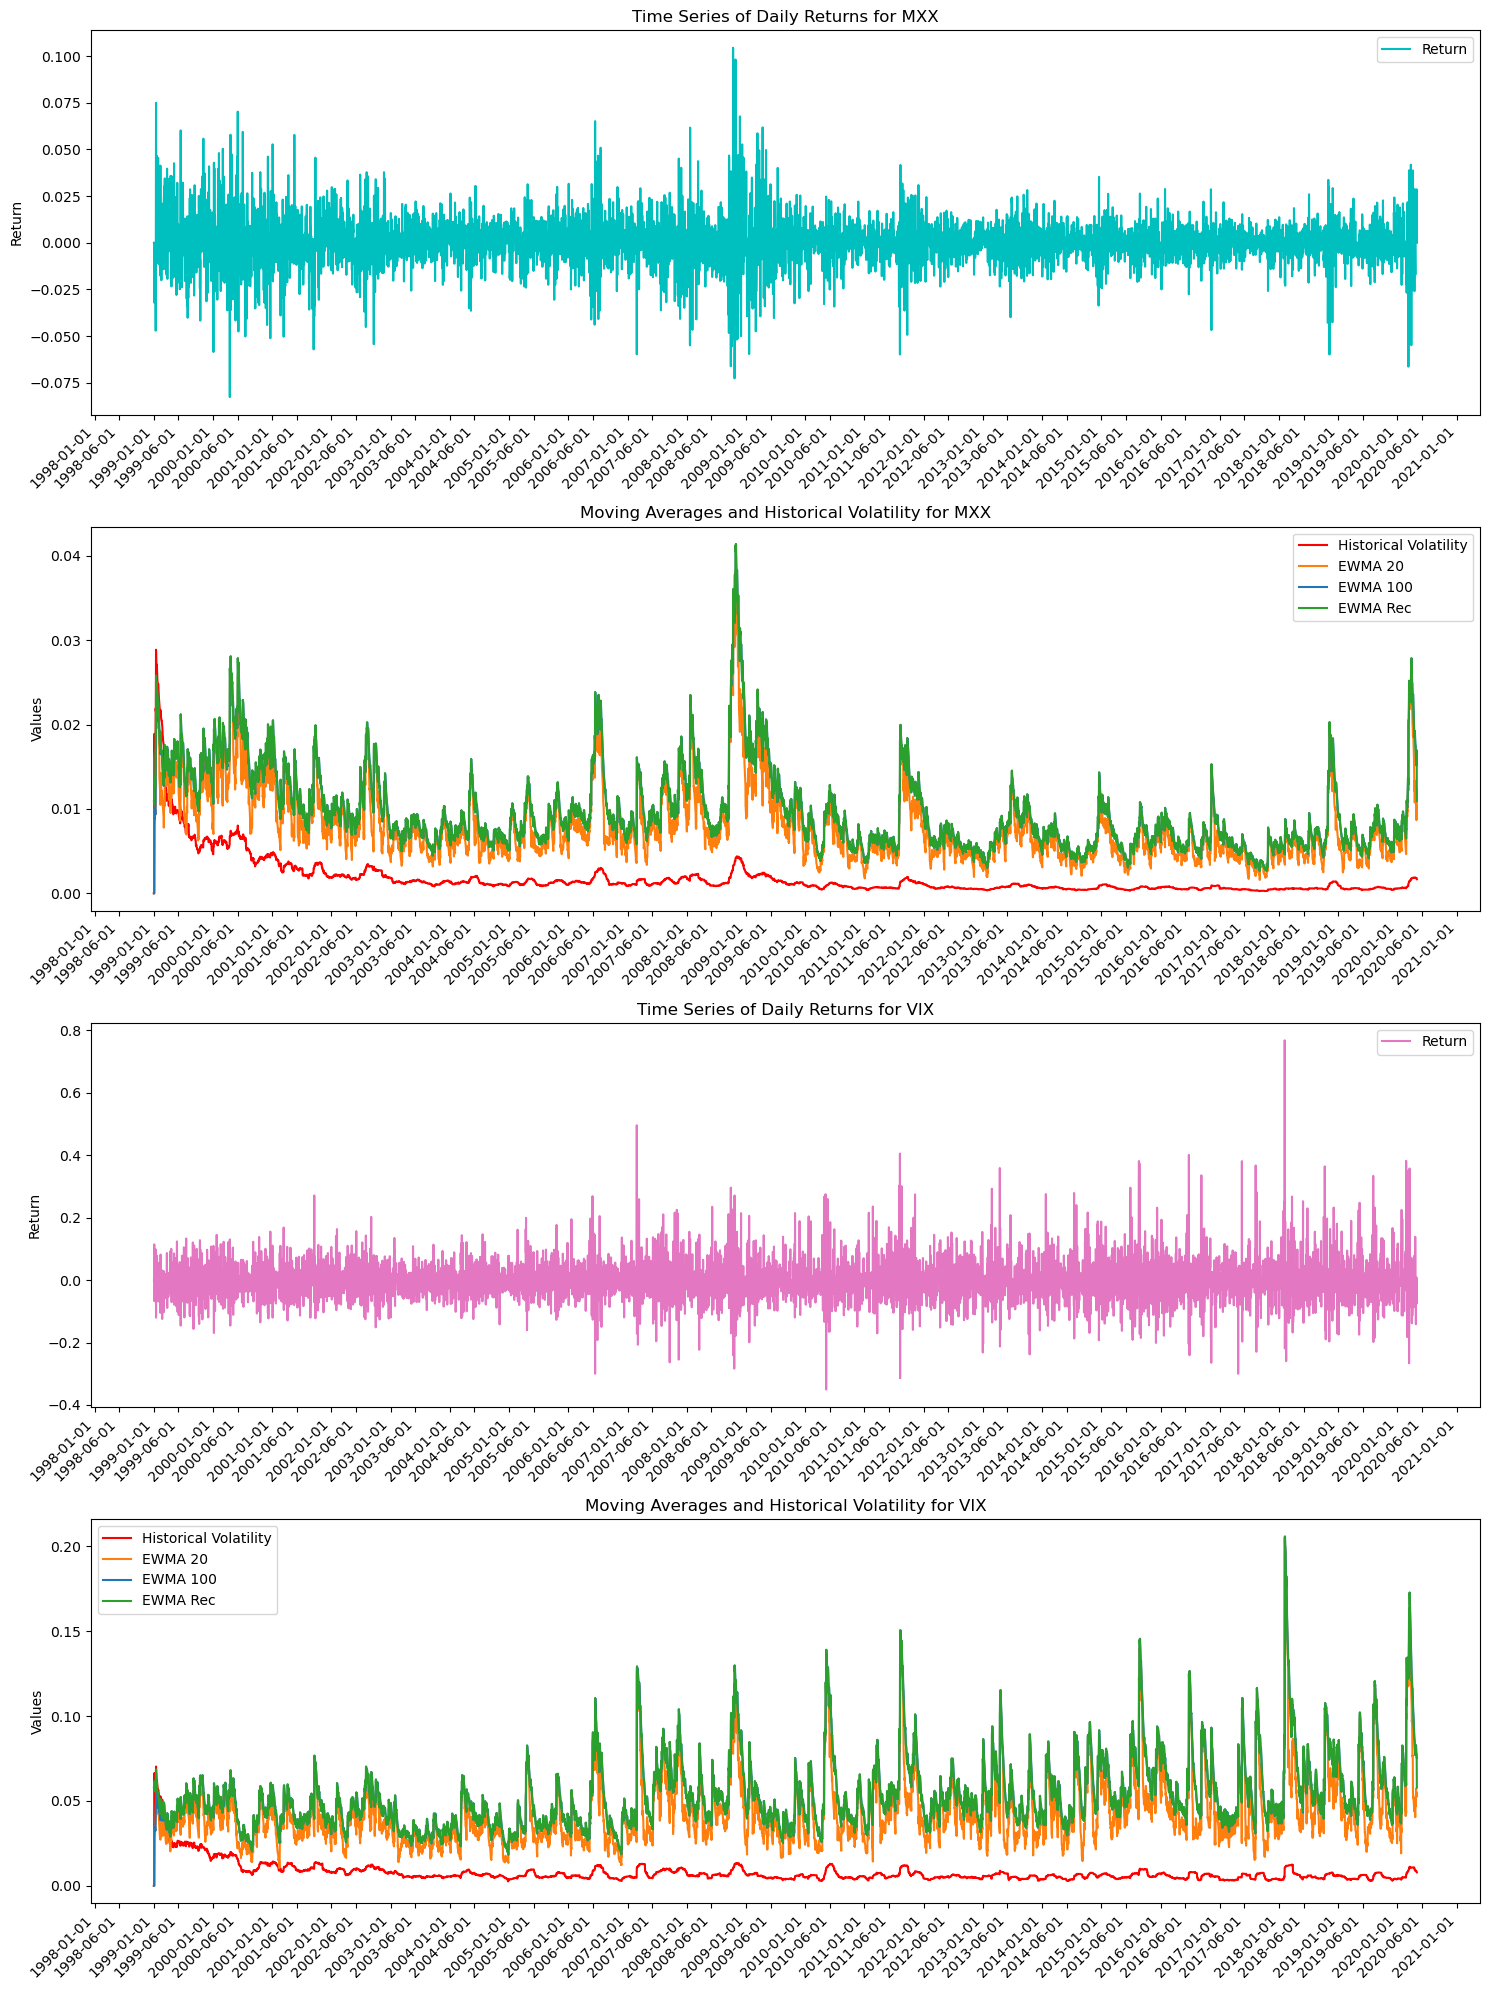

In [11]:
#Graph the different volatility calculations against each other with the time series plot as well

# Group by 'market' column
df_graph = df_stocks[df_stocks['index_time']>100].copy()
df_graph = df_stocks[df_stocks['market']!='BVSP'].copy()
grouped = df_graph.groupby('market')

# Create a separate subplot for each market with two rows per market
fig, axs = plt.subplots(len(grouped) * 2, 1, figsize=(15, 10 * len(grouped)), sharex=False)

# Define a list of colors for multiple lines
colors_time = ['c', 'tab:pink']
colors = ['c', 'm', 'tab:orange', 'tab:blue', 'tab:green']

# Plot each group separately
for i, (market, group_data) in enumerate(grouped):
    # First graph for 'return_ln_daily'
    ax1 = axs[i*2]
    ax1.plot(group_data['date'].values, group_data['return_ln_daily'].values, label='Return', color=colors_time[i])
    ax1.set_ylabel('Return')
    ax1.set_title(f'Time Series of Daily Returns for {market}')
    ax1.legend()
    
    # Set the major tick locator and formatter for the x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate and align date labels
    for label in ax1.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
    
    # Second graph for EWMA and historical volatility
    ax2 = axs[i*2 + 1]
    ax2.plot(group_data['date'].values, group_data['historical_volatility'].values, label='Historical Volatility', color='red')
    ax2.plot(group_data['date'].values, group_data['ewma_eqn20'].values, label='EWMA 20', color=colors[2])
    ax2.plot(group_data['date'].values, group_data['ewma_eqn100'].values, label='EWMA 100', color=colors[3])
    ax2.plot(group_data['date'].values, group_data['ewma_rec'].values, label='EWMA Rec', color=colors[4])
    ax2.set_ylabel('Values')
    ax2.set_title(f'Moving Averages and Historical Volatility for {market}')
    ax2.legend()
    
    # Set the major tick locator and formatter for the x-axis
    ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate and align date labels
    for label in ax2.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(path_out_+'prob1_table.png')  # Saves the plot as a PNG file
plt.show()



Using the tickers 'MXX', and 'VIX' we see a similar method relationship betwen the three methods with the historical volatility (with a window of 50 days) not giving a good indication of volatility at points in time, the EWMA recurisve method and the EWMA window methods are similar/the same and give us the most granular volatility behavior.

When we define a window size (here two examples, one of 20 days and another of 100 days) and use the EWMA equation covered in class, we see that by prioritizing only the most recent returns in the window, we're better capturing the volatility happening in real time as shown by comparing spikes to the time series plot for the funds. When we compare these calculations to the EWMA recursize formula we get almost the exact same results. The difference for the results most likely being that we initialized our EWMA recursion calculation with the overall sample variance of the full population. If we had used the sample variance of the first maybe 100 days instead, we'd likely see the same results.

Comparing these two methods to a regular historical volatility calculation we see that the historical volatility calculation is not well adapted to the behavior we have in our time series. We expected to see this happen as our regular calculation gives equal weight to all previous log returns in our window of 50 days where as we prioritize returns closer to the time we're estimating in the other two methods.

## <a id='part2'>Part 2: Causality Analysis</a>
- **Objective**: Conduct causality analysis with multiple lag variables and time frame windows.
- **Tasks:**
  - Perform stationary test for relevant time period. Manipulate data if necessary.
  - Resample the time series to the weekly and monthly level.
  - Lag 4 returns, lag 4 volatility
  - Perform causality analysis: 4 tables (weekly, returns), (monthly, returns), (weekly, volatility), (monthly, volatility)
  - Correlation assessment

In [2]:
#Import in the cleaned stock data

df_stocks = pd.read_csv(path_out_ + 'df_clean.csv', dtype = str)
df_stocks['date'] = pd.to_datetime(df_stocks['date'])
df_stocks[['open', 'high', 'low', 'close', 'volume', 'adjusted','weekend']] = df_stocks[['open', 'high', 'low', 'close', 'volume', 'adjusted','weekend']].apply(pd.to_numeric)
df_stocks['market'] = df_stocks['market'].str.strip().str.upper()
df_stocks.sort_values(by = ['market','date'], inplace = True)
df_stocks.reset_index(drop = True, inplace = True)

df_stocks['index_time'] = 1
df_stocks['index_time'] = df_stocks.groupby(by = ['market'])['index_time'].cumsum()

#RETURN
#get previous close day
df_stocks['close_lag1'] = df_stocks.groupby(by = ['market'])['close'].shift(1)

#remove the places where we don't have previous day information
df_stocks = df_stocks[df_stocks['index_time']>1]
df_stocks['index_time'] = df_stocks['index_time'] - 1

#use formula to calculate daily natural log return
df_stocks['return_daily'] = df_stocks['close']/df_stocks['close_lag1']
df_stocks['return_ln_daily'] = np.log(df_stocks['close']) - np.log(df_stocks['close_lag1'])
df_stocks.drop(columns = ['close_lag1'], inplace = True)

#VOLATILITY
# Specify lambda
alpha = 1 - PARAM_LAMBDA
# Calculate squared returns
df_stocks['squared_returns'] = df_stocks['return_ln_daily']**2

list_market = df_stocks['market'].unique().tolist()
list_ewma = []
for market in list_market:
    df_market = df_stocks[df_stocks['market']==market].copy()
    df_market['date_'] = df_market['date']
    df_market.set_index('date_', inplace = True)
    # Calculate EWMA using pandas' ewm method
    df_market['sigma_sq_ewma'] = df_market['squared_returns'].ewm(alpha=alpha, adjust=False).mean()
    df_market = df_market[['market','date','sigma_sq_ewma']]
    list_ewma.append(df_market)

df_ewma = pd.concat(list_ewma, ignore_index = True)
df_stocks = df_stocks.merge(df_ewma, how = 'left', on = ['market','date'])
del df_ewma
df_stocks.drop(columns = ['squared_returns'], inplace = True)

#subset just to our relevant time period
# 2018/01 - 2021/12

df_stocks = df_stocks[(df_stocks['date']>=pd.to_datetime('2018-01-01'))&(df_stocks['date']<=pd.to_datetime('2021-12-31'))]

df_stocks.dtypes

df_stocks.describe()

,date,open,high,low,close,volume,adjusted,weekend,index_time,return_daily,return_ln_daily,sigma_sq_ewma
count,11063,11063.000000,11063.000000,11063.000000,11063.000000,1.106300e+04,11063.000000,11063.000000,11063.000000,11063.000000,11063.000000,11063.000000
mean,2019-03-02 00:00:00,19618.034201,19758.342961,19460.613709,19613.624422,5.868815e+08,19613.624422,0.284371,7365.000000,1.000245,-0.000065,0.000576
min,2018-01-01 00:00:00,9.010000,9.310000,8.920000,9.150000,0.000000e+00,9.150000,0.000000,6940.000000,0.766265,-0.266228,0.000008
25%,2018-08-01 00:00:00,5871.209961,5917.816895,5841.933594,5873.875488,5.130000e+04,5873.875488,0.000000,7152.000000,0.997325,-0.002679,0.000034
50%,2019-03-02 00:00:00,10409.269531,10467.980469,10347.099609,10404.000000,5.576430e+07,10404.000000,0.000000,7365.000000,1.000000,0.000000,0.000057
75%,2019-10-01 00:00:00,22734.560547,22857.389649,22680.209961,22758.480469,2.319609e+08,22758.480469,1.000000,7578.000000,1.003428,0.003423,0.000113
max,2020-04-30 00:00:00,119528.000000,119593.000000,118108.000000,119528.000000,9.044690e+09,119528.000000,1.000000,7790.000000,2.155979,0.768245,0.042326
std,NaN,24870.753450,25088.756057,24640.569525,24873.306082,1.226774e+09,24873.306082,0.451135,245.673474,0.026476,0.024281,0.002266


- Perform stationary test for relevant time period. Manipulate data if necessary.

Using the augmented Dickey-Fuller test, we have our null hypothesis that the log daily returns are non-stationary and test this. We find that for each individual ticker in our time period, the test statistic is less than all the critical values and the p-value is less than .05. This leads us to reject our null hypothesis (that the time series is non-stationary) and that our log daily returns for every ticker is stationary.

In [3]:
# Function to test stationarity
def test_stationarity(timeseries):
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  # AIC for selecting best lag
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)



In [4]:
#Test stationarity of natural log daily returns

list_market = df_stocks['market'].unique().tolist()
for market in list_market:
    df_market = df_stocks[df_stocks['market']==market].copy()
    df_market['date_'] = df_market['date']
    df_market.set_index('date_', inplace = True)
    
    # Select the series and perform ADF test
    series = df_market['return_ln_daily']
    print("Market:"+market+'--------------------')
    test_stationarity(series)

Market:BSESN--------------------
Results of Dickey-Fuller Test:
Test Statistic                -5.738936e+00
p-value                        6.341752e-07
#Lags Used                     1.300000e+01
Number of Observations Used    8.370000e+02
Critical Value (1%)           -3.438187e+00
Critical Value (5%)           -2.864999e+00
Critical Value (10%)          -2.568612e+00
dtype: float64
Market:BVSP--------------------
Results of Dickey-Fuller Test:
Test Statistic                  -5.345559
p-value                          0.000004
#Lags Used                      19.000000
Number of Observations Used    831.000000
Critical Value (1%)             -3.438244
Critical Value (5%)             -2.865024
Critical Value (10%)            -2.568625
dtype: float64
Market:FTSE--------------------
Results of Dickey-Fuller Test:
Test Statistic                -6.772351e+00
p-value                        2.622377e-09
#Lags Used                     1.400000e+01
Number of Observations Used    8.360000e+02
Cr

- Resample the time series to the weekly and monthly level.

In [5]:
#resample the times series to a weekly and monthly level, going to take the last value.

list_market = df_stocks['market'].unique().tolist()
list_resample_week = []
list_resample_month = []
for market in list_market:
    df_market = df_stocks[df_stocks['market']==market].copy()
    df_market['date_'] = df_market['date']
    df_market.set_index('date_', inplace = True)

    # Resample to weekly data
    weekly_data = df_market.resample('W').agg({
        'market': 'last',
        'date': 'last',
        'return_daily': 'mean',
        'return_ln_daily': 'mean',
        'sigma_sq_ewma': 'mean'
    })
    list_resample_week.append(weekly_data)

    # Resample to monthly data
    monthly_data = df_market.resample('ME').agg({
        'market': 'last',
        'date': 'last',
        'return_daily': 'mean',  
        'return_ln_daily': 'mean',
        'sigma_sq_ewma': 'mean'
    })
    list_resample_month.append(monthly_data)

df_stocks_weekly = pd.concat(list_resample_week, ignore_index = True)
df_stocks_monthly = pd.concat(list_resample_month, ignore_index = True)

print(df_stocks_weekly.columns)


Index(['market', 'date', 'return_daily', 'return_ln_daily', 'sigma_sq_ewma'], dtype='object')


- Lag 4 returns, lag 4 volatility

In [6]:
#Calculate daily return on close price

def add_four_lags(df_, col, i_):
    for i in range(1, i_+1):
        df_[col+'_lag'+str(i)] = df_.groupby(by = ['market'])[col].shift(i)
    return df_

df_stocks_weekly = add_four_lags(df_stocks_weekly, 'return_daily', 4)
df_stocks_weekly = add_four_lags(df_stocks_weekly, 'return_ln_daily', 4)
df_stocks_weekly = add_four_lags(df_stocks_weekly, 'sigma_sq_ewma', 4)

df_stocks_monthly = add_four_lags(df_stocks_monthly, 'return_daily', 4)
df_stocks_monthly = add_four_lags(df_stocks_monthly, 'return_ln_daily', 4)
df_stocks_monthly = add_four_lags(df_stocks_monthly, 'sigma_sq_ewma', 4)


- Perform causality analysis: 4 tables (weekly, returns), (monthly, returns), (weekly, volatility), (monthly, volatility)

We see that some lag return behavior is indicative of return behavior in other funds on a weekly level but we see very little of this behavior on the monthly level. Similarly to the log daily return analysis, we see that volatility in some funds is indicative of volatility behavior in other funds on a weekly level but we see very little of this behavior on the monthly level.

In [24]:
def run_causality(time, df_, col, df_causality):
    list_market = df_['market'].unique().tolist()

    df_transpose = df_.pivot(index='date', columns='market', values=col)
    df_transpose.columns = list_market

    for market_target in list_market:
        for market_feature in list_market:
            for lag in range(1, 5):
                df_transpose[market_feature+'_lag'+str(lag)] = df_transpose[market_feature].shift(lag)
                # print("Lag:"+str(lag)+'=============')
                test_result = grangercausalitytests(df_transpose[[market_target, market_feature+'_lag'+str(lag)]].dropna(), maxlag=1)
                df_corr = df_transpose[[market_target, market_feature+'_lag'+str(lag)]].dropna()
                distance_correlation = np.corrcoef(df_corr[market_target], df_corr[market_feature+'_lag'+str(lag)])
                for key, value in test_result.items():
                    ssr_ftest = value[0]['ssr_ftest']
                    ssr_chi2test = value[0]['ssr_chi2test']
                    lrtest = value[0]['lrtest']
                    paramf_test = value[0]['params_ftest']
                    df_add = pd.DataFrame({
                        'market_target': market_target,
                        'market_feature': market_feature,
                        'time':time,
                        'var':col,
                        'lag': lag,
                        'f_pvalue': ssr_ftest[1],
                        'chi2_pvalue': ssr_chi2test[1],
                        'lr_pvalue': lrtest[1],
                        'paramf_pvalue':paramf_test[1],
                        'correlation': distance_correlation[0][1]
                    }, index = [0])
                    df_causality = pd.concat([df_causality, df_add], ignore_index = True)

    return df_causality

In [25]:
#causality analysis

# df_causality = pd.DataFrame(columns=['market','time','var','lag','f_pvalue', 'chi2_pvalue', 'lr_pvalue','paramf_pvalue'])
df_causality = pd.DataFrame(columns=['market_target', 'market_feature','time','var','lag','f_pvalue', 'chi2_pvalue', 'lr_pvalue','paramf_pvalue'])

df_causality = run_causality('weekly',df_stocks_weekly,'return_ln_daily',df_causality)
df_causality = run_causality('monthly',df_stocks_monthly,'return_ln_daily',df_causality)
df_causality = run_causality('weekly',df_stocks_weekly,'sigma_sq_ewma',df_causality)
df_causality = run_causality('monthly',df_stocks_monthly,'sigma_sq_ewma',df_causality)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0027  , p=0.0158  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=6.1567  , p=0.0131  , df=1
likelihood ratio test: chi2=6.0039  , p=0.0143  , df=1
parameter F test:         F=6.0027  , p=0.0158  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7029  , p=0.1945  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7470  , p=0.1863  , df=1
likelihood ratio test: chi2=1.7343  , p=0.1879  , df=1
parameter F test:         F=1.7029  , p=0.1945  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6214  , p=0.0194  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.7681  , p=0.0163  , df=1
likelihood ratio test: chi2=5.6315  , p=0.0176  , df=1
parameter F test:         F=5.6214  , p=0.0194  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0902  , p=0.7644  

/tmp/ipykernel_93795/4182895501.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_causality = pd.concat([df_causality, df_add], ignore_index = True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.1216 , p=0.0002  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=15.5093 , p=0.0001  , df=1
likelihood ratio test: chi2=14.5859 , p=0.0001  , df=1
parameter F test:         F=15.1216 , p=0.0002  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6113  , p=0.2068  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.6530  , p=0.1986  , df=1
likelihood ratio test: chi2=1.6416  , p=0.2001  , df=1
parameter F test:         F=1.6113  , p=0.2068  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4941  , p=0.0121  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=6.6635  , p=0.0098  , df=1
likelihood ratio test: chi2=6.4822  , p=0.0109  , df=1
parameter F test:         F=6.4941  , p=0.0121  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5145  , p=0.4747  

In [13]:
df_causality.head()

,market_target,market_feature,time,var,lag,f_pvalue,chi2_pvalue,lr_pvalue,paramf_pvalue
0,BSESN,BSESN,weekly,return_ln_daily,1,0.015764,0.013092,0.014274,0.015764
1,BSESN,BSESN,weekly,return_ln_daily,2,0.194487,0.186257,0.187865,0.194487
2,BSESN,BSESN,weekly,return_ln_daily,3,0.019405,0.016320,0.017640,0.019405
3,BSESN,BSESN,weekly,return_ln_daily,4,0.764427,0.760887,0.760933,0.764427
4,BSESN,BVSP,weekly,return_ln_daily,1,0.000772,0.000470,0.000643,0.000772


In [55]:
#write the code to display the causality results

def display_causality(time_, var_, time_name_, var_name_):
    df_ = df_causality[(df_causality['time']==time_)&(df_causality['var']==var_)].copy()
    list_market = df_['market_target'].unique().tolist()
    df_['significance'] = 0
    # cndn = (df_['f_pvalue']<=.05)&(df_['chi2_pvalue']<=.05)&(df_['lr_pvalue']<=.05)&(df_['paramf_pvalue']<=.05)
    cndn = (df_['f_pvalue']<=.05)&(df_['paramf_pvalue']<=.05)
    df_.loc[cndn, 'significance'] = 1
    df_['significance'] = df_['significance'].apply(str)
    df_agg = df_.groupby(by = ['market_target','market_feature'], as_index = False)['significance'].agg(', '.join)
    df_agg['significance'] = '(' + df_agg['significance'] + ')'
    df_agg.columns = ['Market', 'market_feature','significance']

    # Using pivot to reshape the DataFrame
    df_display = df_agg.pivot(index='Market', columns='market_feature', values='significance')

    # Rename the columns as required
    df_display.columns = list_market

    # Reset the index to have 'ticker' as a column (if necessary)
    df_display.reset_index(inplace=True)
    df_display.rename(columns = {'Market':' '}, inplace = True)

    table_fig = ff.create_table(df_display)

    table_fig.write_image(path_out_+'prob2_'+time_name_+'_'+var_name_+'.png', width=1000, height=650)  # Saves the plot as a PNG file
    table_fig.show()



In [56]:
display_causality('weekly', 'return_ln_daily', 'Weekly', 'Log Daily Return')


In [61]:
display_causality('monthly', 'return_ln_daily', 'Monthly', 'Log Daily Return')


In [62]:
display_causality('weekly', 'sigma_sq_ewma', 'Weekly', 'Spill Over Volatility')


In [63]:
display_causality('monthly', 'sigma_sq_ewma', 'Monthly', 'Spill Over Volatility')


In [28]:
df_causality.to_excel(path_out_+'df_causality.xlsx', index = False)


- Dive into Causality Examples

To further dive into these relationships, we create an overlapping time series plot of average log daily return and average volatility on the weekly and monthly level for the tickers $\textit{FTSE}$ and $\textit{N225}$, specifically chosen as both tickers yielded statistically significant causality results for two of the lag options with regard to weekly log daily return and three or more of the lag options with regard to weekly volatility.

We see that the average log daily return and average volatility on the week does not differ too greatly so that we could understand that if we were to lag the data by a week, it would perform reasonably as a predictor to the other funds log daily return. 

On the opposite end of the spectrum we see that if we were to lag the monthly return or monthly volatility by a month it would not act as a good indicator as this behavior has a larger value gap month to month than on the weekly level. Further giving us insight into why we saw many statistically significant causality results on the weekly level rather than on the monthly level.

In [57]:
df_stocks_weekly.columns

Index(['market', 'date', 'return_daily', 'return_ln_daily', 'sigma_sq_ewma',
       'return_daily_lag1', 'return_daily_lag2', 'return_daily_lag3',
       'return_daily_lag4', 'return_ln_daily_lag1', 'return_ln_daily_lag2',
       'return_ln_daily_lag3', 'return_ln_daily_lag4', 'sigma_sq_ewma_lag1',
       'sigma_sq_ewma_lag2', 'sigma_sq_ewma_lag3', 'sigma_sq_ewma_lag4'],
      dtype='object')

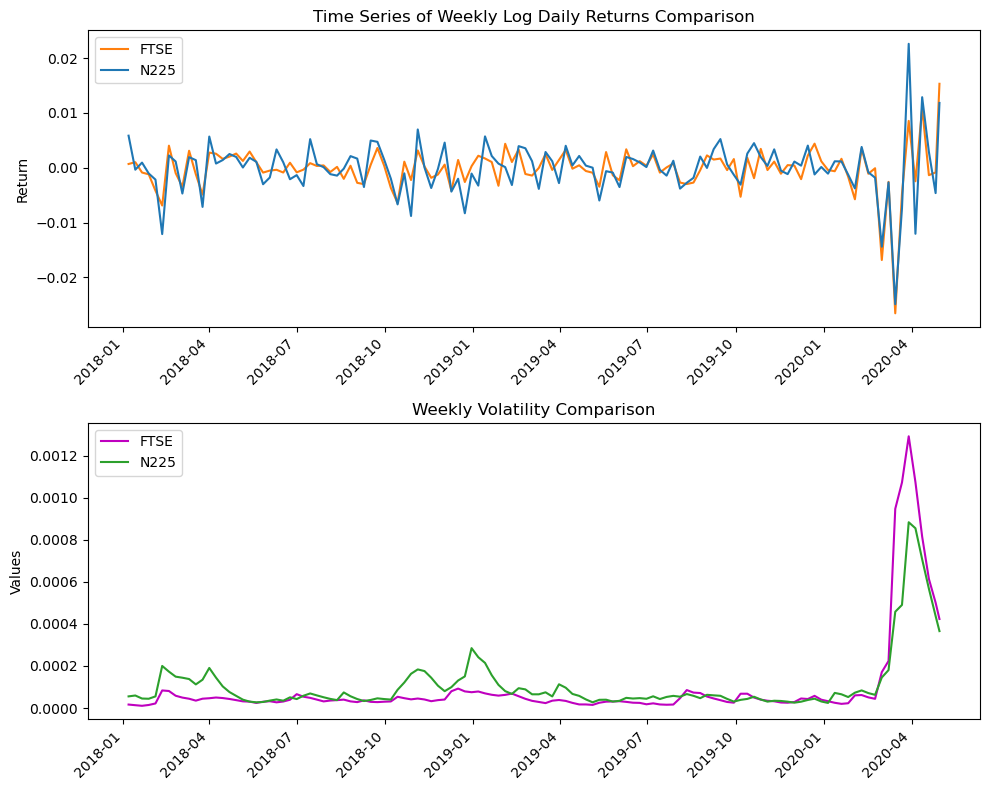

In [76]:
#display return time series and volatility example on the week level

df_ = df_stocks_weekly.copy()

df_graph = df_[(df_['market']=='FTSE')|(df_['market']=='N225')].copy()
grouped = df_graph.groupby('market')

# Create a separate subplot for each market with two rows per market
# fig, axs = plt.subplots(len(grouped) * 2, 1, figsize=(15, 10 * len(grouped)), sharex=False)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Adjust figure size as necessary

# Define a list of colors for multiple lines
colors_time = ['tab:orange', 'tab:blue']
colors = ['m', 'tab:green']

# Plot each group separately
for i, (market, group_data) in enumerate(grouped):
    if i == 0:
        ax1 = axs[0]
        ax2 = axs[1]

    # First graph for 'return_ln_daily'
    ax1.plot(group_data['date'].values, group_data['return_ln_daily'].values, label=market, color=colors_time[i])
    ax1.set_ylabel('Return')
    ax1.set_title(f'Time Series of Weekly Log Daily Returns Comparison')
    ax1.legend()
        
    # Rotate and align date labels
    for label in ax1.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
    
    # Second graph for EWMA and historical volatility
    
    ax2.plot(group_data['date'].values, group_data['sigma_sq_ewma'].values, label=market, color=colors[i])
    ax2.set_ylabel('Values')
    ax2.set_title(f'Weekly Volatility Comparison')
    ax2.legend()
        
    # Rotate and align date labels
    for label in ax2.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(path_out_+'prob2_weekly_ex_table.png')  # Saves the plot as a PNG file
plt.show()



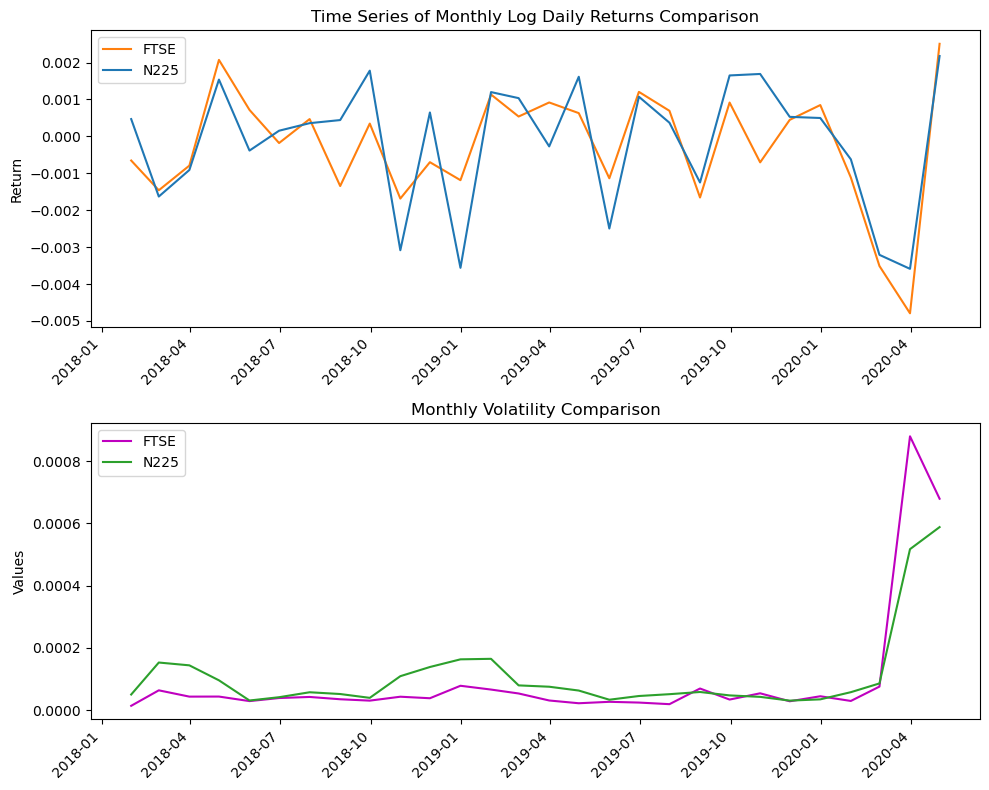

In [77]:
#display return time series and volatility example on the month level

df_ = df_stocks_monthly.copy()

df_graph = df_[(df_['market']=='FTSE')|(df_['market']=='N225')].copy()
grouped = df_graph.groupby('market')

# Create a separate subplot for each market with two rows per market
# fig, axs = plt.subplots(len(grouped) * 2, 1, figsize=(15, 10 * len(grouped)), sharex=False)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Adjust figure size as necessary

# Define a list of colors for multiple lines
colors_time = ['tab:orange', 'tab:blue']
colors = ['m', 'tab:green']

# Plot each group separately
for i, (market, group_data) in enumerate(grouped):
    if i == 0:
        ax1 = axs[0]
        ax2 = axs[1]

    # First graph for 'return_ln_daily'
    ax1.plot(group_data['date'].values, group_data['return_ln_daily'].values, label=market, color=colors_time[i])
    ax1.set_ylabel('Return')
    ax1.set_title(f'Time Series of Monthly Log Daily Returns Comparison')
    ax1.legend()
        
    # Rotate and align date labels
    for label in ax1.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
    
    # Second graph for EWMA and historical volatility
    
    ax2.plot(group_data['date'].values, group_data['sigma_sq_ewma'].values, label=market, color=colors[i])
    ax2.set_ylabel('Values')
    ax2.set_title(f'Monthly Volatility Comparison')
    ax2.legend()
        
    # Rotate and align date labels
    for label in ax2.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(path_out_+'prob2_monthly_ex_table.png')  # Saves the plot as a PNG file
plt.show()


- Correlation assessment

To evaluate whether this is true causality or is in fact correlation, we perform a correlation assessment. We conduct our correlation assessment using a distance correlation calculation. For ease of visualization we create an indicator where an absolute value of correlation greater than .7 is a 1 indicating strong correlation and 0 otherwise. 

Continuing with our example of looking specifically at tickers $\textit{FTSE}$ and $\textit{N225}$ our causality tests indicated that using a lag return or lag volatility offered good predictive insight into the other fund's return or volatility on a weekly level. But we have that the distance correlation values are less than zero for all lag values on the weekly level for log daily returns but not volatility. This indicates to us that there is not in fact true causality between these funds and the lagged returns but there could be when it comes to volatility.

Zooming out at the overall analysis between all tickers we see a similar pattern emerge where we saw many causality indicators on the weekly level for both log daily returns and volatility but we only see correlation supporting this when it comes to volatility behavior. Overall what we are seeing from both the causality test and correlation assessment is spill over volatility, a situation in financial markets where volatility in one fund can impact the volatility of another fund. 

In [26]:
df_causality.columns

Index(['market_target', 'market_feature', 'time', 'var', 'lag', 'f_pvalue',
       'chi2_pvalue', 'lr_pvalue', 'paramf_pvalue', 'correlation'],
      dtype='object')

In [49]:
def display_correlation(time_, var_, time_name_, var_name_):
    df_ = df_causality[(df_causality['time']==time_)&(df_causality['var']==var_)].copy()
    list_market = df_['market_target'].unique().tolist()
    # df_['significance'] = df_['correlation'].round(decimals = 1)
    df_['significance'] = 0
    df_.loc[df_['correlation'].abs() >= .7, 'significance'] = 1

    df_['significance'] = df_['significance'].apply(str)
    df_agg = df_.groupby(by = ['market_target','market_feature'], as_index = False)['significance'].agg(', '.join)
    df_agg['significance'] = '(' + df_agg['significance'] + ')'
    df_agg.columns = ['Market', 'market_feature','significance']
    # df_agg['significance'] = df_agg['significance'].str.replace('0.','.')

    # Using pivot to reshape the DataFrame
    df_display = df_agg.pivot(index='Market', columns='market_feature', values='significance')

    # Rename the columns as required
    df_display.columns = list_market

    # Reset the index to have 'ticker' as a column (if necessary)
    df_display.reset_index(inplace=True)
    df_display.rename(columns = {'Market':' '}, inplace = True)

    table_fig = ff.create_table(df_display)

    # table_fig.write_image(path_out_+'prob2_'+time_name_+'_'+var_name_+'_correlation.png', width=1300, height=900)  # Saves the plot as a PNG file
    table_fig.write_image(path_out_+'prob2_'+time_name_+'_'+var_name_+'_correlation.png', width=1000, height=650)  # Saves the plot as a PNG file
    table_fig.show()

In [54]:
display_correlation('weekly', 'return_ln_daily', 'Weekly', 'Log Daily Return')

In [51]:
display_correlation('monthly', 'return_ln_daily', 'Monthly', 'Log Daily Return')

In [52]:
display_correlation('weekly', 'sigma_sq_ewma', 'Weekly', 'Spill Over Volatility')

In [53]:
display_correlation('monthly', 'sigma_sq_ewma', 'Monthly', 'Spill Over Volatility')

## <a id='part3'>Part 3: Modeling</a>
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - Data Analysis & Cleaning
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: Random Forest
  - Create an ARMA model as our baseline
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.
  - Compare models and analyze performance

### Load and Preprocess Data

In [ ]:
sp500_data = pd.read_csv(path_in_ + 'goyal-welch2022Monthly.csv', sep=',')
sp500_data.columns = sp500_data.columns.str.lower().str.strip()
sp500_data['date'] = pd.to_datetime(sp500_data['yyyymm'], format='%Y%m')
sp500_data['index'] = sp500_data['index'].astype(str).str.replace(',', '').astype(float)
sp500 = sp500_data[sp500_data['date'] >= '1926-01-01']

sp500_head = sp500.head()
sp500_info = sp500.info()
sp500_description = sp500.describe()

sp500_head, sp500_info, sp500_description


<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 660 to 1823
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymm      1164 non-null   int64         
 1   index       1164 non-null   float64       
 2   d12         1164 non-null   float64       
 3   e12         1164 non-null   float64       
 4   b/m         1164 non-null   float64       
 5   tbl         1164 non-null   float64       
 6   aaa         1164 non-null   float64       
 7   baa         1164 non-null   float64       
 8   lty         1164 non-null   float64       
 9   ntis        1153 non-null   float64       
 10  rfree       1164 non-null   float64       
 11  infl        1164 non-null   float64       
 12  ltr         1164 non-null   float64       
 13  corpr       1164 non-null   float64       
 14  svar        1164 non-null   float64       
 15  csp         788 non-null    float64       
 16  crsp_spvw   1164 non-null  

(     yyyymm  index     d12    e12       b/m     tbl     aaa     baa     lty  \
 660  192601  12.74  0.6075  1.249  0.387671  0.0349  0.0482  0.0609  0.0374   
 661  192602  12.18  0.6150  1.248  0.394363  0.0318  0.0477  0.0602  0.0372   
 662  192603  11.46  0.6225  1.248  0.494091  0.0314  0.0479  0.0605  0.0371   
 663  192604  11.72  0.6300  1.247  0.482917  0.0308  0.0474  0.0598  0.0368   
 664  192605  11.81  0.6375  1.246  0.483860  0.0317  0.0471  0.0586  0.0369   
 
      ntis     rfree      infl     ltr   corpr      svar  csp  crsp_spvw  \
 660   NaN  0.002925  0.000000  0.0138  0.0072  0.000857  NaN  -0.001783   
 661   NaN  0.002908  0.000000  0.0063  0.0045  0.001099  NaN  -0.033296   
 662   NaN  0.002650 -0.005587  0.0041  0.0084  0.006016  NaN  -0.057708   
 663   NaN  0.002617  0.005618  0.0076  0.0097  0.001466  NaN   0.038522   
 664   NaN  0.002567 -0.005587  0.0014  0.0044  0.000690  NaN   0.013623   
 
      crsp_spvwx       date  
 660   -0.003980 1926-01-01  


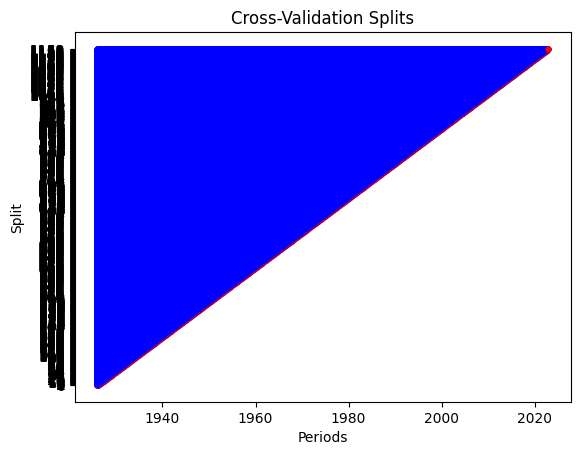

     yyyymm  index     d12    e12       b/m     tbl     aaa     baa     lty  \
660  192601  12.74  0.6075  1.249  0.387671  0.0349  0.0482  0.0609  0.0374   
661  192602  12.18  0.6150  1.248  0.394363  0.0318  0.0477  0.0602  0.0372   
662  192603  11.46  0.6225  1.248  0.494091  0.0314  0.0479  0.0605  0.0371   
663  192604  11.72  0.6300  1.247  0.482917  0.0308  0.0474  0.0598  0.0368   
664  192605  11.81  0.6375  1.246  0.483860  0.0317  0.0471  0.0586  0.0369   

         ntis     rfree      infl     ltr   corpr      svar       csp  \
660       NaN  0.002925  0.000000  0.0138  0.0072  0.000857       NaN   
661       NaN  0.002908  0.000000  0.0063  0.0045  0.001099       NaN   
662  0.015991  0.002650 -0.005587  0.0041  0.0084  0.006016  0.000364   
663  0.015991  0.002617  0.005618  0.0076  0.0097  0.001466  0.000364   
664  0.015991  0.002567 -0.005587  0.0014  0.0044  0.000690  0.000364   

     crsp_spvw  crsp_spvwx       date  
660  -0.001783   -0.003980 1926-01-01  
661  -

In [ ]:
#impute csp missing values using PanelSplit and KNN
sp500_df = sp500.sort_values('date')
features = ['csp', 'ntis']
n_splits = len(pd.date_range(start=sp500_df['date'].min(), end=sp500_df['date'].max(), freq='M')) - 1  # minus 1 because the first period is only used for training
panel_split = PanelSplit(periods=sp500_df['date'], n_splits=n_splits, gap=0, test_size=1, plot=True)
imputed_data, fitted_imputers = panel_split.cross_val_fit_transform(KNNImputer(), sp500_df[features], include_test_in_fit=True)
sp500_df[features] = imputed_data

print(sp500_df.head())


### Feature engineering

#### Financial Indicators
Compute the indicators (code borrowed from PythonLab3_2_GWcausalSP500)

In [ ]:
sp500_df['index'] = pd.to_numeric(sp500_df['index'], errors='coerce')
sp500_df['d12'] = pd.to_numeric(sp500_df['d12'], errors='coerce')
sp500_df['rfree'] = pd.to_numeric(sp500_df['rfree'], errors='coerce')

print(sp500_df.dtypes)

yyyymm                 int64
index                float64
d12                  float64
e12                  float64
b/m                  float64
tbl                  float64
aaa                  float64
baa                  float64
lty                  float64
ntis                 float64
rfree                float64
infl                 float64
ltr                  float64
corpr                float64
svar                 float64
csp                  float64
crsp_spvw            float64
crsp_spvwx           float64
date          datetime64[ns]
dtype: object


In [ ]:
# dividend-price ratio (dp)
sp500_df['dp'] = np.log(sp500_df['d12']) - np.log(sp500_df['index'])

# Book-to-Market (b/m)
sp500_df.rename(columns={'b/m': 'bm'}, inplace=True)

print(sp500_df)

#### Create Target Variables

In [ ]:
sp500_df['logret'] = np.log(sp500_df['index']).diff() #log return of sp500

sp500_df['logindex'] = np.log(sp500_df['index']) #log of index

sp500_df['index_return'] = sp500_df['index'].pct_change()  #percentage change
sp500_df['direction'] = (sp500_df['index_return'] > 0).astype(int) #direction

print(sp500_df[['date', 'logindex', 'logret', 'direction']].head())

          date  logindex    logret  direction
660 1926-01-01  2.544747       NaN          0
661 1926-02-01  2.499795 -0.044951          0
662 1926-03-01  2.438863 -0.060933          0
663 1926-04-01  2.461297  0.022434          1
664 1926-05-01  2.468947  0.007650          1


#### Create Lag Variables

In [ ]:
#lags for dp
sp500_df['dp_lag1'] = sp500_df['dp'].shift(1)
sp500_df['dp_lag2'] = sp500_df['dp'].shift(2)
sp500_df['dp_lag3'] = sp500_df['dp'].shift(3)
sp500_df['dp_lag4'] = sp500_df['dp'].shift(4)

#lags for svar
sp500_df['svar_lag1'] = sp500_df['svar'].shift(1)
sp500_df['svar_lag2'] = sp500_df['svar'].shift(2)
sp500_df['svar_lag3'] = sp500_df['svar'].shift(3)
sp500_df['svar_lag4'] = sp500_df['svar'].shift(4)

#lags for bm
sp500_df['bm_lag1'] = sp500_df['bm'].shift(1)
sp500_df['bm_lag2'] = sp500_df['bm'].shift(2)
sp500_df['bm_lag3'] = sp500_df['bm'].shift(3)
sp500_df['bm_lag4'] = sp500_df['bm'].shift(4)

#lags for target: log of price
sp500_df['logindex_lag1'] = sp500_df['logindex'].shift(1)
sp500_df['logindex_lag2'] = sp500_df['logindex'].shift(2)
sp500_df['logindex_lag3'] = sp500_df['logindex'].shift(3)
sp500_df['logindex_lag4'] = sp500_df['logindex'].shift(4)

#lags for target: log of return
sp500_df['logret_lag1'] = sp500_df['logret'].shift(1)
sp500_df['logret_lag2'] = sp500_df['logret'].shift(2)
sp500_df['logret_lag3'] = sp500_df['logret'].shift(3)
sp500_df['logret_lag4'] = sp500_df['logret'].shift(4)

#lags for target: direction
sp500_df['direction_lag1'] = sp500_df['direction'].shift(1)
sp500_df['direction_lag2'] = sp500_df['direction'].shift(2)
sp500_df['direction_lag3'] = sp500_df['direction'].shift(3)
sp500_df['direction_lag4'] = sp500_df['direction'].shift(4)

sp500_df.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,logindex_lag3,logindex_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,direction_lag1,direction_lag2,direction_lag3,direction_lag4
660,192601,12.74,0.6075,1.249,0.387671,0.0349,0.0482,0.0609,0.0374,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,192602,12.18,0.6150,1.248,0.394363,0.0318,0.0477,0.0602,0.0372,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
662,192603,11.46,0.6225,1.248,0.494091,0.0314,0.0479,0.0605,0.0371,NaN,...,NaN,NaN,-0.044951,NaN,NaN,NaN,0.0,0.0,NaN,NaN
663,192604,11.72,0.6300,1.247,0.482917,0.0308,0.0474,0.0598,0.0368,NaN,...,2.544747,NaN,-0.060933,-0.044951,NaN,NaN,0.0,0.0,0.0,NaN
664,192605,11.81,0.6375,1.246,0.483860,0.0317,0.0471,0.0586,0.0369,NaN,...,2.499795,2.544747,0.022434,-0.060933,-0.044951,NaN,1.0,0.0,0.0,0.0


In [ ]:
#check for missing values
sp500_df_filtered = sp500_df[sp500_df['date'] >= '1927-01-01']
sp500_nulls = sp500_df_filtered.isna().sum()
print(sp500_nulls)

#save data
sp500_df_filtered.to_csv(path_out_ + 'sp500_clean.csv', index=False)

Plot to compare index and log of index

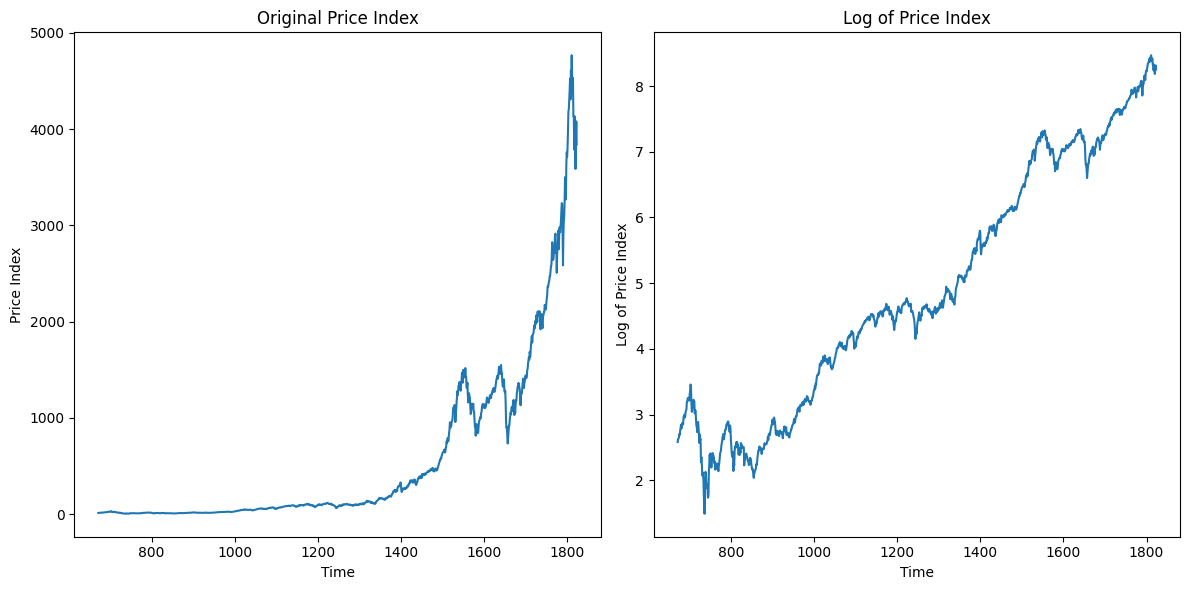

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sp500_df_filtered['index'])
plt.title('Original Price Index')
plt.xlabel('Time')
plt.ylabel('Price Index')

plt.subplot(122)
plt.plot(sp500_df_filtered['logindex'])
plt.title('Log of Price Index')
plt.xlabel('Time')
plt.ylabel('Log of Price Index')

plt.tight_layout()
plt.show()


### Feature selection: Random Forest

In [ ]:
#load the clean data
sp500_df_filtered = pd.read_csv(path_out_ + 'sp500_clean.csv')

In [ ]:
features = ['dp', 'svar', 'bm','dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4',
        'logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4',
       'direction_lag1', 'direction_lag2', 'direction_lag3', 'direction_lag4']

#prepare the data
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

X_train = train_data[features]
Y_train = {
    'logindex': train_data['logindex'],
    'logret': train_data['logret'],
    'direction': train_data['direction']
}

# since direction is binary, we define the model types for each target type
model_types = {
    'logret': RandomForestRegressor,
    'logindex': RandomForestRegressor,
    'direction': RandomForestClassifier
}

n_estimators = 100
top_n = 7
feature_importances = {}
top_features = {}

for target, y_train in Y_train.items():
    valid_idx = y_train.notna()
    model = model_types[target](n_estimators=n_estimators, random_state=42)
    model.fit(X_train[valid_idx], y_train[valid_idx])

    # Store and sort feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importances[target] = importances
    top_features[target] = X_train.columns[indices[:top_n]]

    print(f"Top {top_n} important features for {target}:", top_features[target])

Top 7 important features for logindex: Index(['logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'bm', 'dp', 'dp_lag1'],
      dtype='object')
Top 7 important features for logret: Index(['svar', 'bm_lag2', 'dp', 'svar_lag1', 'logret_lag3', 'svar_lag2',
       'logret_lag2'],
      dtype='object')
Top 7 important features for direction: Index(['svar', 'dp', 'bm', 'logret_lag1', 'svar_lag1', 'dp_lag1',
       'logret_lag2'],
      dtype='object')


### Model 1: Baseline Model - ARMA


#### Stationary Test

In [ ]:
logindex_df = sp500_df_filtered[['date', 'logindex']]
logret_df = sp500_df_filtered[['date','logret']]
direction_df = sp500_df_filtered[['date','direction']]

print(logret_df)

            date    logret
0     1927-01-01 -0.020975
1     1927-02-01  0.046589
2     1927-03-01  0.006482
3     1927-04-01  0.017082
4     1927-05-01  0.050905
...          ...       ...
1147  2022-08-01 -0.043367
1148  2022-09-01 -0.098049
1149  2022-10-01  0.076835
1150  2022-11-01  0.052358
1151  2022-12-01 -0.060782

[1152 rows x 2 columns]


In [ ]:
#function to test if the time series is stationary using the Augmented Dickey–Fuller test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] > 0.05:
      print("Data is not stationary")
    else:
      print("Data is stationary")

In [ ]:
targets = ['logindex', 'logret', 'direction']
for target in targets:
  test_stationarity(sp500_df_filtered[target])

ADF Statistic: 0.6551436672311199
p-value: 0.9888988290720038
Critical Values:
	1%: -3.436150192101723
	5%: -2.8641011312034057
	10%: -2.5681336157882373
Data is not stationary
ADF Statistic: -8.092508431685228
p-value: 1.3662615637881076e-12
Critical Values:
	1%: -3.4361450520165464
	5%: -2.8640988637413893
	10%: -2.5681324081722314
Data is stationary
ADF Statistic: -12.79841838220568
p-value: 6.83650539998581e-24
Critical Values:
	1%: -3.436064032324827
	5%: -2.864063122757945
	10%: -2.5681133731450605
Data is stationary


The null hypothesis is that there IS a unit root(meaning the data is not statonary). If the ADF statistic is more negative than the critical values, the null hypothesis can be rejected with the corresponding confidence level.

In our case, the ADF statistic of 0.655 is not more negative than any of the critical values, confirming that the time series can be considered to have a unit root and is non-stationary at the 1%, 5%, and 10% levels. So we cannot reject the null hypothesis. Since the data is not stationary, we use differencing to stabalize them.

In [ ]:
logindex_df['difflogindex'] = logindex_df['logindex'].diff()
logindex_df.dropna(inplace=True)

test_stationarity(logindex_df['difflogindex'])

ADF Statistic: -8.0913501187124
p-value: 1.375564169394405e-12
Critical Values:
	1%: -3.436150192101723
	5%: -2.8641011312034057
	10%: -2.5681336157882373
Data is stationary


<ipython-input-76-bb34d725f743>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logindex_df['difflogindex'] = logindex_df['logindex'].diff()
<ipython-input-76-bb34d725f743>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logindex_df.dropna(inplace=True)


#### Find Best Parameters, Fit & Predict
Now we use the auto_arima function from the pmdarima library to determine the best parameters (p and q) for an ARIMA model

In [ ]:
#function to find the best parameters for the arma model, generate predictons and calculate metrics
def train_evaluate_arima(df, start_date, end_date, target):
    train = df[df['date'] < start_date]
    test = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    y_train = train[['date', target]]
    y_test = test[['date', target]]

    y_train.set_index('date', inplace=True)
    y_test.set_index('date', inplace=True)

    model = auto_arima(y_train, seasonal=True, error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)
    pred_arma = model.predict(n_periods=len(y_test)) #predict

    y_test['pred_arma'] = pred_arma

    mse = mean_squared_error(y_test[target], y_test['pred_arma'])
    mae = mean_absolute_error(y_test[target], y_test['pred_arma'])
    r2 = r2_score(y_test[target], y_test['pred_arma'])

    performance_metrics_arma = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance metrics:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")

    return model, performance_metrics_arma, y_test

In [ ]:
#run for logindexdiff
model_index, metrics_index, index_predictions = train_evaluate_arima(logindex_df, '2018-01-01', '2021-12-31', 'difflogindex')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3281.494, Time=2.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3262.219, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3267.232, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3267.479, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3255.443, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3264.346, Time=1.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3265.257, Time=1.25 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3276.556, Time=2.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3280.234, Time=1.84 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3265.491, Time=0.38 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3270.560, Time=1.89 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3269.755, Time=3.38 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3277.542, Time=2.71 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3275.672, Time=0.99 sec

Best model:  ARIMA

<ipython-input-77-416250510282>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred_arma'] = pred_arma


In [ ]:
last_known_value = logindex_df['logindex'].iloc[-len(index_predictions['pred_arma'])-1]
restored_predictions = index_predictions['pred_arma'].cumsum() + last_known_value
restored_predictions = pd.concat([pd.Series([last_known_value], index=[logindex_df.index[-len(index_predictions)-1]]), restored_predictions])
# Dropping the first row of the series
restored_predictions = restored_predictions[1:]
restored_predictions

In [ ]:
# Convert 'date' in test_data
test_data['date'] = pd.to_datetime(test_data['date'])
restored_predictions = restored_predictions.reset_index().rename(columns={'index': 'date'})
restored_predictions['date'] = pd.to_datetime(restored_predictions['date'])
restored_predictions['date'] = restored_predictions['date'].dt.to_period('M').dt.to_timestamp()
restored_predictions.rename(columns={0: 'logindex_arma_pred'}, inplace=True)

restored_predictions

In [ ]:
#merge onto our test_data
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.merge(restored_predictions, on=['date'], how='left')

test_data.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,direction_lag4,logindex_gp_pred,logret_gp_pred,direction_gp_pred,direction_gp_pred_prob,direction_nn_pred,direction_nn_prob,logindex_nn_pred,logret_nn_pred,logindex_arma_pred
0,201801,2823.81,49.2890,111.7333,0.222519,0.0141,0.0355,0.0426,0.0284,-0.019044,...,1.0,7.943586,0.015600,1,0.833652,1,0.979039,7.560549,0.009812,7.833524
1,201802,2713.83,49.6460,113.5867,0.232478,0.0157,0.0382,0.0451,0.0301,-0.018320,...,1.0,7.907733,-0.045071,0,0.325329,1,0.020136,7.581529,0.006311,7.840779
2,201803,2640.87,50.0030,115.4400,0.259537,0.0170,0.0387,0.0464,0.0285,-0.018221,...,1.0,7.879765,-0.016791,0,0.444364,1,0.177951,7.577617,0.005447,7.843311
3,201804,2648.05,50.3321,117.7867,0.258892,0.0176,0.0385,0.0467,0.0300,-0.018606,...,1.0,7.881836,0.004943,1,0.640021,1,0.885870,7.573417,0.004736,7.847308
4,201805,2705.27,50.6612,120.1333,0.256213,0.0186,0.0400,0.0483,0.0289,-0.018934,...,1.0,7.901834,0.010402,1,0.734331,1,0.961268,7.573011,0.013143,7.854270


In [ ]:
#run for logret
model_logret, metrics_logret, logret_predictions = train_evaluate_arima(logret_df, '2018-01-01', '2021-12-31', 'logret')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3284.885, Time=1.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3265.986, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3270.941, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3271.186, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3259.280, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3268.065, Time=1.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3267.565, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3283.878, Time=3.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3283.989, Time=3.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3269.201, Time=0.87 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3274.278, Time=2.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3273.472, Time=1.63 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3281.269, Time=2.28 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3279.460, Time=0.93 sec

Best model:  ARIMA

In [ ]:
# Convert 'date' in test_data
logret_predictions = logret_predictions.reset_index().rename(columns={'index': 'date'})
logret_predictions['date'] = pd.to_datetime(logret_predictions['date'])
restored_predictions['date'] = restored_predictions['date'].dt.to_period('M').dt.to_timestamp()
logret_predictions.rename(columns={'pred_arma': 'logret_arma_pred'}, inplace=True)
logret_predictions.drop(columns=['logret'], inplace=True)

In [ ]:
#merge onto our test_data
test_data = test_data.merge(logret_predictions, on=['date'], how='left')

test_data.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,logindex_gp_pred,logret_gp_pred,direction_gp_pred,direction_gp_pred_prob,direction_nn_pred,direction_nn_prob,logindex_nn_pred,logret_nn_pred,logindex_arma_pred,logret_arma_pred
0,201801,2823.81,49.2890,111.7333,0.222519,0.0141,0.0355,0.0426,0.0284,-0.019044,...,7.943586,0.015600,1,0.833652,1,0.979039,7.560549,0.009812,7.833524,0.006675
1,201802,2713.83,49.6460,113.5867,0.232478,0.0157,0.0382,0.0451,0.0301,-0.018320,...,7.907733,-0.045071,0,0.325329,1,0.020136,7.581529,0.006311,7.840779,0.006773
2,201803,2640.87,50.0030,115.4400,0.259537,0.0170,0.0387,0.0464,0.0285,-0.018221,...,7.879765,-0.016791,0,0.444364,1,0.177951,7.577617,0.005447,7.843311,0.002467
3,201804,2648.05,50.3321,117.7867,0.258892,0.0176,0.0385,0.0467,0.0300,-0.018606,...,7.881836,0.004943,1,0.640021,1,0.885870,7.573417,0.004736,7.847308,0.003991
4,201805,2705.27,50.6612,120.1333,0.256213,0.0186,0.0400,0.0483,0.0289,-0.018934,...,7.901834,0.010402,1,0.734331,1,0.961268,7.573011,0.013143,7.854270,0.006489


### Model 2: Gaussian Process

#### GridSearch CV & Prediction -Continuous Targets



In [ ]:
targets = ['logindex', 'logret']

sp500_df_filtered['date'] = pd.to_datetime(sp500_df_filtered['date'])
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
#test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

In [ ]:
top_features_cont = {key: top_features[key] for key in targets}

print(top_features_cont)

{'logindex': Index(['logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'bm', 'dp', 'dp_lag1'],
      dtype='object'), 'logret': Index(['svar', 'bm_lag2', 'dp', 'svar_lag1', 'logret_lag3', 'svar_lag2',
       'logret_lag2'],
      dtype='object'), 'direction': Index(['svar', 'dp', 'bm', 'logret_lag1', 'svar_lag1', 'dp_lag1',
       'logret_lag2'],
      dtype='object')}


In [ ]:
#gridsearch for continuous targets
models = {}
pred_gp = {}
performance_metrics = {}

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

#loop to perform a gridsearch for each target variable and predict
for target, features in top_features_cont.items():
    # Prepare feature matrix and target vector
    X_train = train_data[list(features)]
    y_train = train_data[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)  # Scale the features

    #diffkernels
    white_kernel = WhiteKernel(noise_level=0.5)
    constant_kernel = ConstantKernel(1.0)
    rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
    matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
    rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
    dot_product_kernel = DotProduct(sigma_0=1)

    kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel, rq_kernel]

    param_grid = {
        'kernel': kernel_options,
        'alpha': [1e-4]
    }
    gp = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=20, random_state=0)

    grid_search = GridSearchCV(estimator=gp,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv = tscv)

    grid_search.fit(X_scaled, y_train)

    # Store results and best model
    models[target] = grid_search.best_estimator_

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {target}: {grid_search.best_score_}")

    # Transform test data using the same scaler fitted on the training data
    X_test = test_data[list(features)]
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on test data
    pred_gp[target] = models[target].predict(X_test_scaled)
    test_data[f'{target}_gp_pred'] = pred_gp[target]

    # Calculate performance metrics
    mse = mean_squared_error(test_data[target], pred_gp[target])
    mae = mean_absolute_error(test_data[target], pred_gp[target])
    r2 = r2_score(test_data[target], pred_gp[target])

    performance_metrics[target] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance for {target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")


#### GridSearch CV - Direction

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
target = 'direction'
#gridsearch for binary target
features = top_features['direction']
X_train = train_data[features]
y_train = train_data['direction'].astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

#diffkernels
white_kernel = WhiteKernel(noise_level=0.5)
constant_kernel = ConstantKernel(1.0)
rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
dot_product_kernel = DotProduct(sigma_0=1)

kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel, rq_kernel]

param_grid = {
    'kernel': kernel_options,
    'max_iter_predict': [500, 1000],
}

gp_classifier = GaussianProcessClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gp_classifier, param_grid=param_grid, scoring='roc_auc', cv=tscv, verbose=1)
grid_search.fit(X_scaled, y_train)

models[target]= grid_search.best_estimator_
print(f"Best parameters for direction: {grid_search.best_params_}")
print(f"Best cross-validation score for direction: {grid_search.best_score_}")


#### Predictions - Direction

In [ ]:
X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)

#class labels for the test set
pred_gp_dir = models[target].predict(X_test_scaled)
#probability estimates for the binary classes
pred_gp_dir_prob = models[target].predict_proba(X_test_scaled)

true_labels = test_data['direction'].astype(int)

test_data[f'direction_gp_pred'] = pred_gp_dir
test_data[f'direction_gp_pred_prob']= pred_gp_dir_prob[:, 1]

# Calculate performance metrics
roc_auc = roc_auc_score(test_data[target].dropna(), test_data[f'{target}_gp_pred_prob'])
accuracy = accuracy_score(test_data[target], test_data[f'{target}_gp_pred'])
logloss = log_loss(test_data[target], test_data[f'{target}_gp_pred_prob'])

performance_metrics[target] = {
    'ROC_AUC': roc_auc,
    'Accuracy': accuracy,
    'Log Loss': logloss
}

print(f"Performance for {target}:")
print(f"  ROC AUC: {roc_auc}")
print(f"  Accuracy: {accuracy}")
print(f"  Log Loss: {logloss}")

Performance for direction:
  ROC AUC: 0.9978991596638656
  Accuracy: 0.9375
  Log Loss: 0.3305283491332704


<ipython-input-51-82b26ab63cbf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'direction_gp_pred'] = pred_gp_dir
<ipython-input-51-82b26ab63cbf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'direction_gp_pred_prob']= pred_gp_dir_prob[:, 1]


### Model 3: NNET

#### GridSearch CV & Prediction -Continuous Targets


In [ ]:
#gridsearch & prediction for price and return
tscv = TimeSeriesSplit(n_splits=5)
models_nn = {}
pred_nn = {}
performance_metricsnn = {}

In [ ]:
#gridsearch & prediction for price and return
tscv = TimeSeriesSplit(n_splits=5)
models_nn = {}
pred_nn = {}
performance_metricsnn = {}

#loop to perform a gridsearch for each target variable and predict
for target, features in top_features_cont.items():
    X_train = train_data[list(features)]
    y_train = train_data[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'hidden_layer_sizes': [(20,), (20, 20), (50,), (100,), (100, 100), (50, 50), (100, 50, 25)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.0001, 0.001]
    }

    mlp = MLPRegressor(max_iter=10000,
                      random_state=42,
                      verbose=True,
                      early_stopping=True,
                      validation_fraction=0.1)

    grid_search = GridSearchCV(mlp, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y_train)

    models_nn[target] = grid_search.best_estimator_

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {target}: {grid_search.best_score_}")

    X_test = test_data[list(features)]
    X_test_scaled = scaler.transform(X_test)

    pred_nn[target] = models_nn[target].predict(X_test_scaled)
    test_data[f'{target}_nn_pred'] = pred_nn[target]

    mse = mean_squared_error(test_data[target], pred_nn[target])
    mae = mean_absolute_error(test_data[target], pred_nn[target])
    r2 = r2_score(test_data[target], pred_nn[target])

    performance_metricsnn[target] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance for {target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")

#### Gridsearch CV - Direction

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(20,), (20, 20), (50,), (100,), (100, 100), (50, 50), (100, 50, 25)],
    'activation': ['sigmoid', 'softmax', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001]
}

target = 'direction'
features = top_features[target]

X_train = train_data[list(features)]
y_train = train_data[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

mlp = MLPClassifier(max_iter=10000,
                   random_state=42,
                   verbose=True,
                   early_stopping=True,
                   validation_fraction=0.1)

grid_search_nn_dir = GridSearchCV(mlp, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_nn_dir.fit(X_scaled, y_train.dropna())

models_nn[target] = grid_search_nn_dir.best_estimator_

print(f"Best parameters for {target}: {grid_search_nn_dir.best_params_}")
print(f"Best cross-validation score for {target}: {grid_search_nn_dir.best_score_}")


#### Predictions - Direction

In [ ]:
#logret preds with NN
X_test = test_data[list(features)]
X_test_scaled = scaler.transform(X_test)

pred_nn[target] = models_nn[target].predict(X_test_scaled)
test_data[f'{target}_nn_pred'] = pred_nn[target]

pred_nn_dir_prob = models_nn[target].predict_proba(x_test_scaled)
test_data[f'{target}_nn_prob'] = pred_nn_dir_prob[:, 1]

# Calculate performance metrics
roc_auc = roc_auc_score(test_data[target].dropna(), test_data[f'{target}_nn_prob'])
accuracy = accuracy_score(test_data[target], test_data[f'{target}_nn_pred'])
logloss = log_loss(test_data[target], test_data[f'{target}_nn_prob'])

performance_metricsnn[f'{target}_nn'] = {
    'ROC_AUC': roc_auc,
    'Accuracy': accuracy,
    'Log Loss': logloss
}

print(f"Performance for {target}:")
print(f"  ROC AUC: {roc_auc}")
print(f"  Accuracy: {accuracy}")
print(f"  Log Loss: {logloss}")

Performance for direction:
  ROC AUC: 0.976890756302521
  Accuracy: 0.9583333333333334
  Log Loss: 0.25272702340335024


In [ ]:
#save test data with the predctions
test_data.to_csv(path_out_ + 'pred.csv', index=False)

### Plotting Results

In [ ]:
test_data = pd.read_csv(path_out_ + 'pred.csv')

#### Logindex Plot

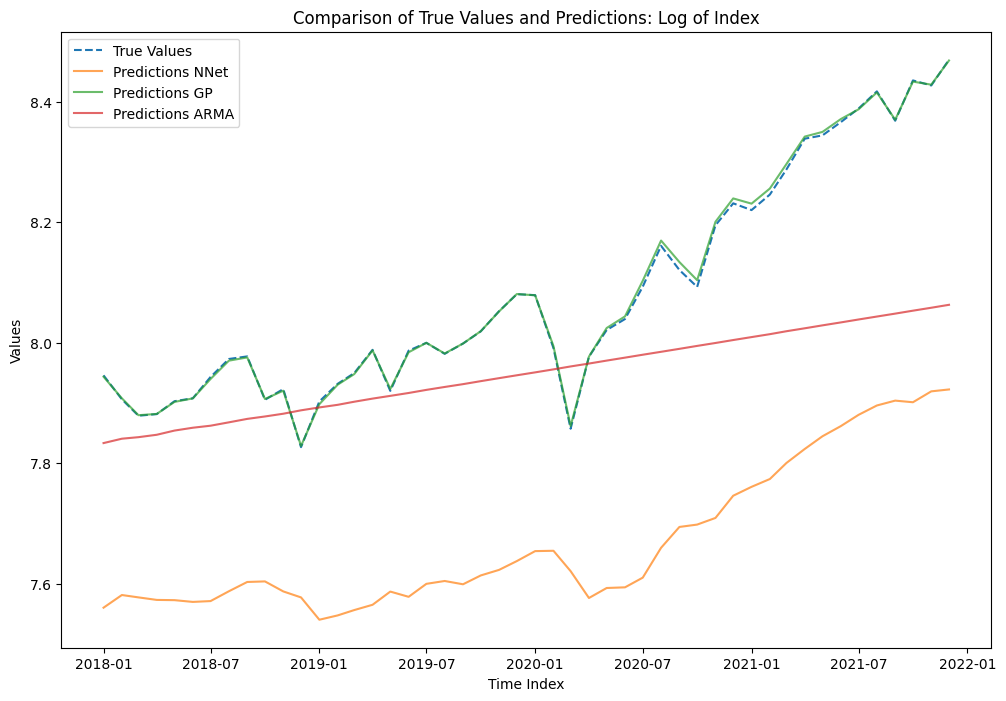

In [ ]:
# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_nn': test_data['logindex_nn_pred'], 'pred_gp': test_data['logindex_gp_pred'], 'pred_arma': test_data['logindex_arma_pred']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logindex_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions: Log of Index')

# Display legend
plt.legend()

# Show the plot
plt.show()

#### Logret (Returns) Plot

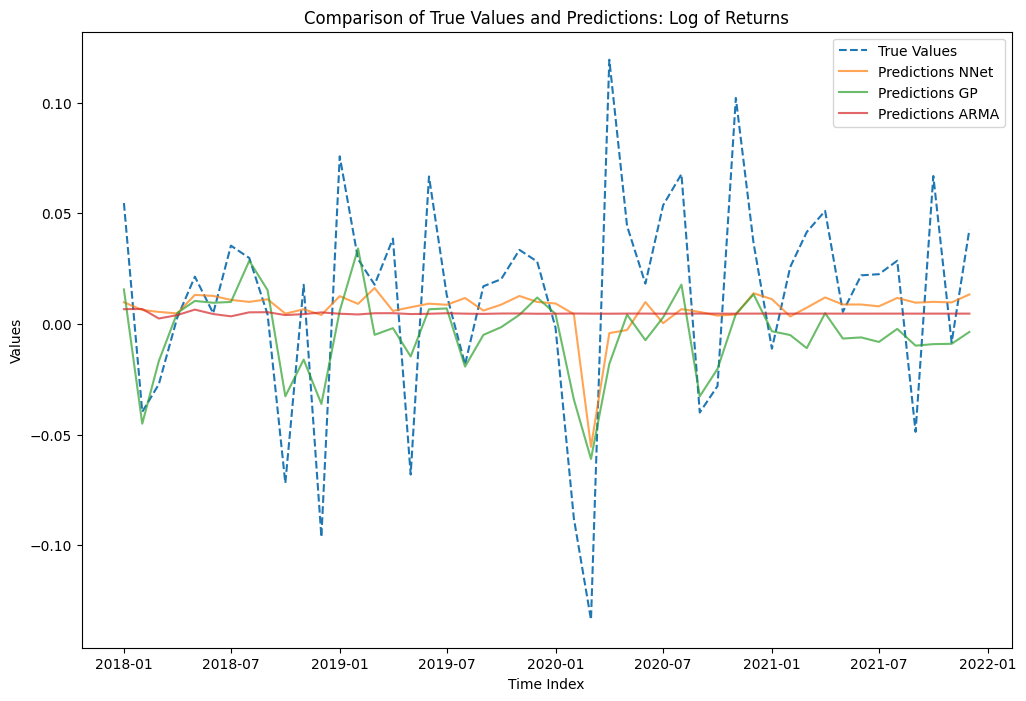

In [ ]:
#Compare ARMA model to NN and Gaussian Process Regression
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': test_data['logret_nn_pred'], 'pred_gp': test_data['logret_gp_pred'], 'pred_arma': test_data['logret_arma_pred']}
)

df_logret_res['date'] = test_data.date
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logret_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions: Log of Returns')

# Display legend
plt.legend()

# Show the plot
plt.show()

#### Direction Plot

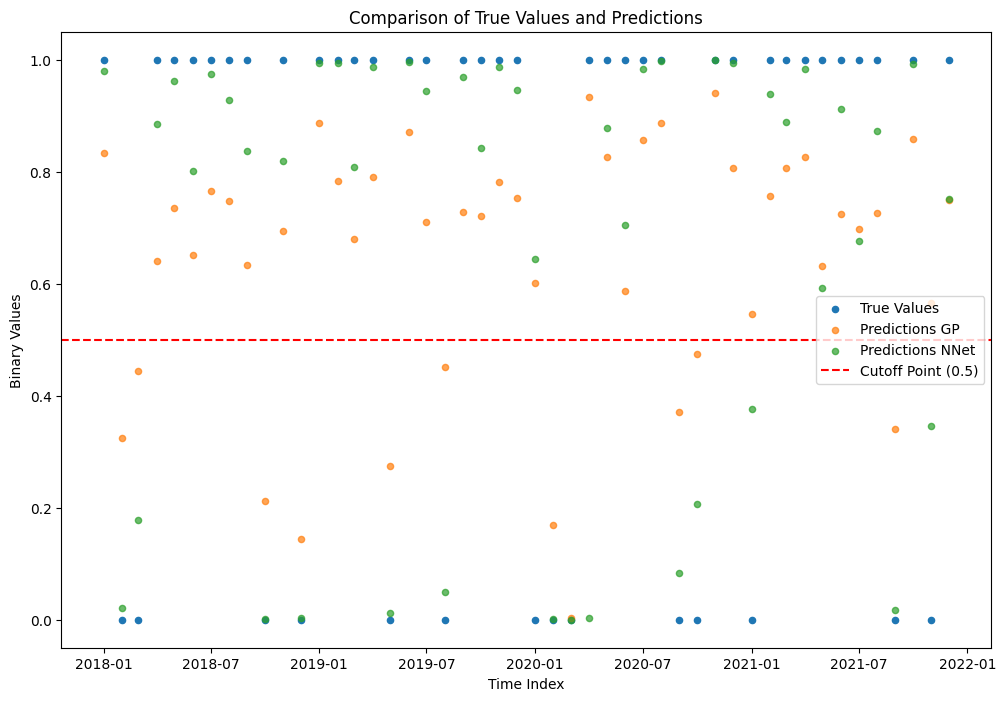

In [ ]:
# Evaluation of Results
df_direction_res = pd.DataFrame(
    {'true': test_data['direction'], 'pred_nn': test_data['direction_nn_prob'], 'pred_gp': test_data['direction_gp_pred_prob']}
)

df_direction_res['date'] = test_data.date
df_direction_res['date'] = pd.to_datetime(df_direction_res['date'])
df_direction_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))

# Plot True Values
plt.scatter(df_direction_res.index, df_direction_res['true'], label='True Values', marker='o', s=20)

# Plot Predictions for NNet and GP
plt.scatter(df_direction_res.index, df_direction_res['pred_gp'], label='Predictions GP', alpha=0.7, s=20)
plt.scatter(df_direction_res.index, df_direction_res['pred_nn'], label='Predictions NNet', alpha=0.7, s=20)

# Adding a horizontal line at y=0.5
plt.axhline(y=0.5, color='r', linestyle='--', label='Cutoff Point (0.5)')

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Binary Values')
plt.title('Comparison of True Values and Predictions: Direction')

# Display legend
plt.legend()

# Show the plot
plt.show()


### All Results

In [ ]:
#function to calculate regression metrics and store in a DF
def calculate_regression_metrics(df, true_col, pred_col, model_name, results_df=None):
    # metrics
    mse = mean_squared_error(df[true_col], df[pred_col])
    mae = mean_absolute_error(df[true_col], df[pred_col])
    r_squared = r2_score(df[true_col], df[pred_col])

    new_results = pd.DataFrame({
        'Model': [model_name],
        'MSE': [mse],
        'MAE': [mae],
        'R^2': [r_squared]
    })

    if results_df is not None:
        results_df = pd.concat([results_df, new_results], ignore_index=True)
    else:
        results_df = new_results

    return results_df

#function to calculate classification metrics and store in DF
def calculate_binary_classification_metrics(df, true_col, pred_col, prob_col, model_name, results_df=None):
    accuracy = accuracy_score(df[true_col], df[pred_col])
    roc_auc = roc_auc_score(df[true_col], df[prob_col])  # Use probabilities directly for ROC-AUC
    precision = precision_score(df[true_col], df[pred_col])

    new_results = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC': [roc_auc],
    })

    if results_df is not None:
        results_df = pd.concat([results_df, new_results], ignore_index=True)
    else:
        results_df = new_results

    return results_df

In [ ]:
price_metrics_df = None
price_metrics_df = calculate_regression_metrics(test_data, 'logindex', 'logindex_gp_pred', 'GP', price_metrics_df)
price_metrics_df = calculate_regression_metrics(test_data, 'logindex', 'logindex_nn_pred', 'NN', price_metrics_df)
price_metrics_df = calculate_regression_metrics(test_data, 'logindex', 'logindex_arma_pred', 'ARMA', price_metrics_df)
display(price_metrics_df)

,Model,MSE,MAE,R^2
0,GP,0.000023,0.003365,0.999316
1,NN,0.176130,0.412895,-4.269913
2,ARMA,0.033520,0.140587,-0.002951


In [ ]:
return_metrics_df = None
return_metrics_df = calculate_regression_metrics(test_data, 'logret', 'logret_gp_pred', 'GP', return_metrics_df)
return_metrics_df = calculate_regression_metrics(test_data, 'logret', 'logret_nn_pred', 'NN', return_metrics_df)
return_metrics_df = calculate_regression_metrics(test_data, 'logret', 'logret_arma_pred', 'ARMA', return_metrics_df)
display(return_metrics_df)

,Model,MSE,MAE,R^2
0,GP,0.001818,0.032583,0.246409
1,NN,0.002148,0.036008,0.109698
2,ARMA,0.002464,0.038506,-0.021407


In [ ]:
# Example usage:
direction_metrics_df = None  # Initialize an empty DataFrame or load an existing one
direction_metrics_df = calculate_binary_classification_metrics(test_data, 'direction', 'direction_gp_pred', 'direction_gp_pred_prob', 'GP', direction_metrics_df)
direction_metrics_df = calculate_binary_classification_metrics(test_data, 'direction', 'direction_nn_pred', 'direction_nn_prob' ,'NN', direction_metrics_df)
display(direction_metrics_df)

,Model,Accuracy,ROC-AUC
0,GP,0.937500,0.997899
1,NN,0.958333,0.976891
